In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import fetch_20newsgroups
from  sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats 
%matplotlib inline
COLOR_TREAT = "#2ecc71"
COLOR_NO_TREAT = "#e74c3c"
%config InlineBackend.figure_format = 'retina'
# ignore annoying warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Question 1: Propensity score matching

We will work with a dataset from Robert LaLonde's study Evaluating the Econometric Evaluations of Training Programs.

The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Our task is to determine the effectiveness of the "treatment" represented by the job training program.

The features of this dataset are:

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)


First let's import and have a look at the data :

Notice that the `race` variable is changed to `black` and `hispan`. Therefore, someone with `black=0` and `hispan=0` is White according to this study.

In [51]:
#let's import the dataset and observe the first rows
lalonde = pd.read_csv('lalonde.csv')
lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## 1. Naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.

In [52]:
#We define this function to have clean distribution plot as we are going to use them a lot through our analysis
def plot_distrib(s1, s2, title, xLabel, yLabel, ax=None):
    bins = np.histogram(s1)[1]
    sns.distplot(s1, kde=False, color=COLOR_NO_TREAT, norm_hist=True, ax=ax, bins=bins)
    sns.distplot(s2, kde=False, color=COLOR_TREAT, norm_hist=True, ax=ax, bins=bins)
    if ax is None:
        plt.title(title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.legend(['No treatment', 'Treatment'])
    else:
        ax.set_title(title)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.legend(['No treatment', 'Treatment'])

First, let's compare the two distributions. The distribution in red is the distribution of the revenues in 78 for the people that did not take part in the job training program (no treatment), whereas the one in green is the distribution of the revenues in 78 for the people that took part in the job training program (treatment).

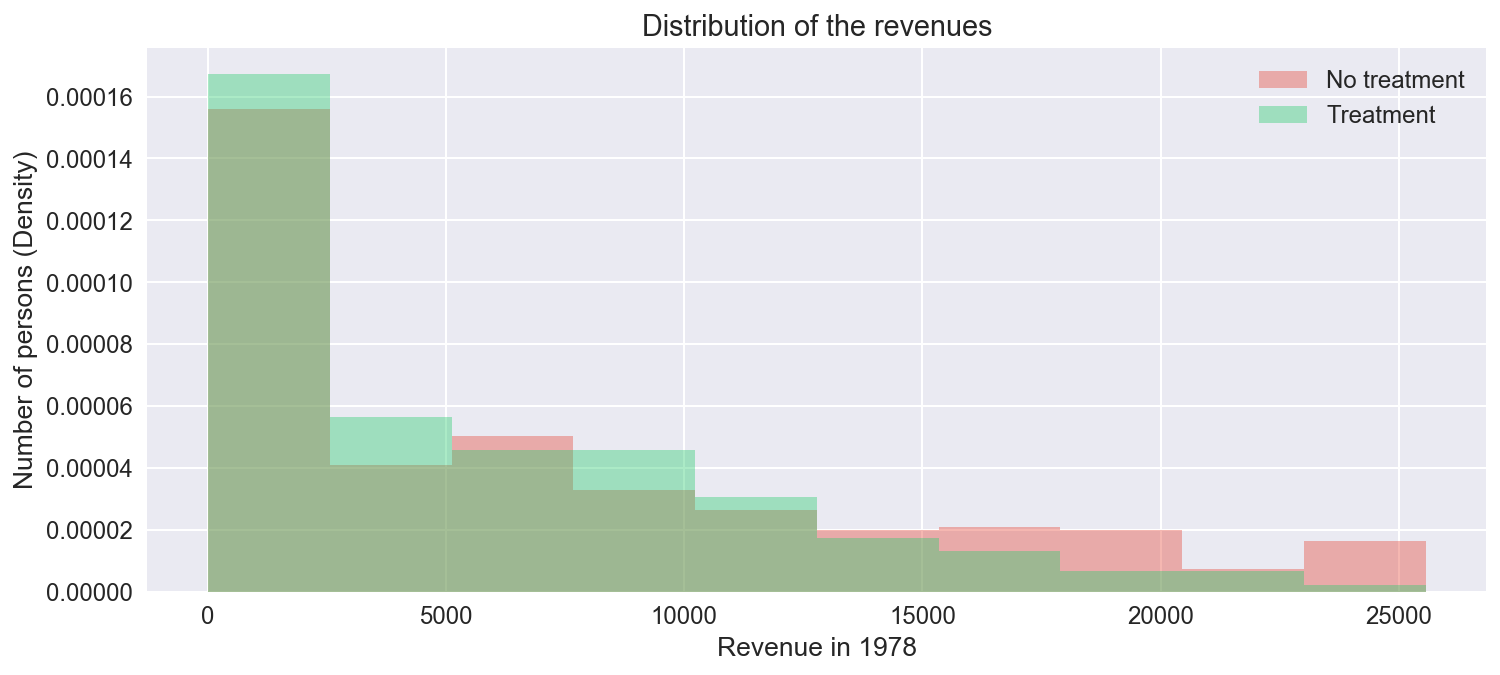

In [53]:
#let's plot the two distributions
plt.figure(figsize=(12,5))
plot_distrib(s1=lalonde.re78[lalonde['treat'] == 0], s2=lalonde.re78[lalonde['treat'] == 1], title='Distribution of the revenues', ax=None, xLabel='Revenue in 1978', yLabel='Number of persons (Density)')

We observe that people that did not take part in the training programs seem to have better earnings. Indeed, the histogram shows that the green bars are higher than the red ones for the small revenues whereas the red bars are higher for the higher revenues.

A Kolmogorov–Smirnov 2 sample test will help us be sure of our analysis.

The Kolmogorov–Smirnov 2 sample test tests whether 2 samples are drawn from the same distribution. If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [54]:
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 're78'
ks = stats.ks_2samp(lalonde[feature][lalonde['treat'] == 0], lalonde[feature][lalonde['treat'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

re78       0.099       0.153


The p-value is high (way above the usual threshold of 0.05), therefore we can not reject the null hypothesis that says that the distributions of the two samples are the same.

If the distributions are not equal for the two populations, it seems that it is worst for the treated population.
From this analysis we can conclude that the training does not seem to be effective.

Now, let's compare other indicators for the people that have/have not participated in the job training:

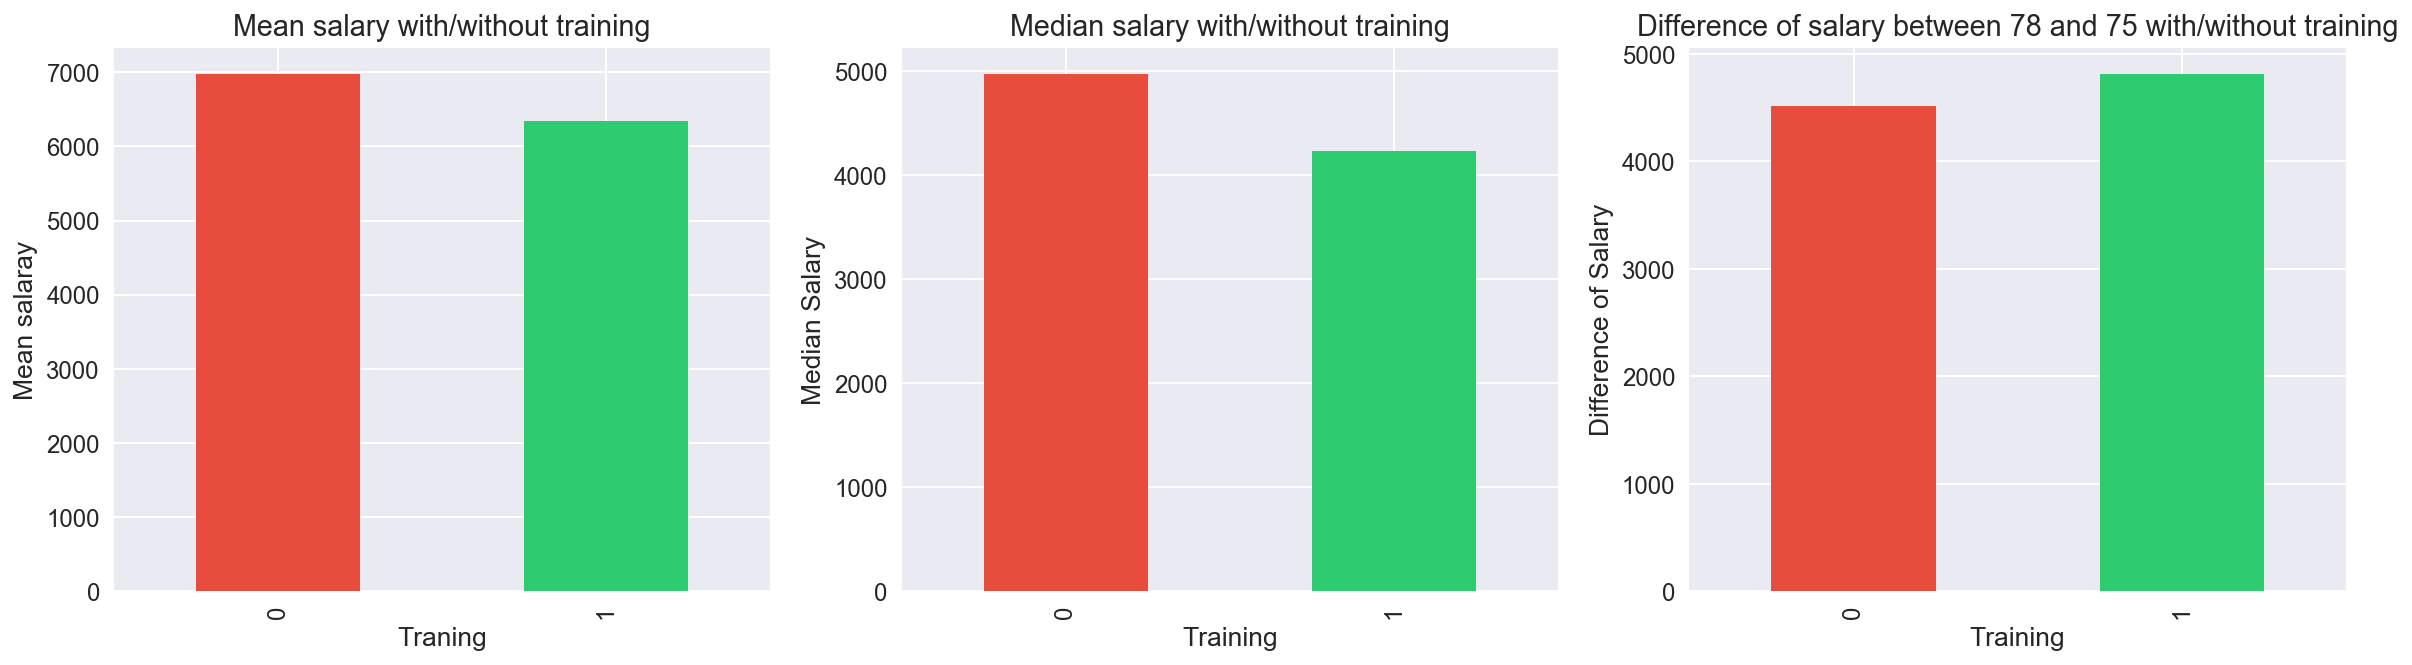

In [55]:
lalonde['diff'] = lalonde['re78'] - lalonde['re75']

plt.figure(figsize=(20,5))
axes = plt.subplot(131)
lalonde.groupby(['treat'])['re78'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Mean salary with/without training')
plt.ylabel('Mean salaray')
plt.xlabel('Traning')
plt.subplot(132)
lalonde.groupby(['treat'])['re78'].median().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Median salary with/without training')
plt.ylabel('Median Salary')
plt.xlabel('Training')
plt.subplot(133)
lalonde.groupby(['treat'])['diff'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Difference of salary between 78 and 75 with/without training')
plt.ylabel('Difference of Salary')
plt.xlabel('Training')

lalonde = lalonde.drop('diff',1)

First, let's compare the mean and the median of the revenues in 78 for the two groups. We notice that both of these indicators are higher for the people that did not take part in the training. 

We thought that another interesting indicator would be to compare the difference of earnings between 78 and 75 for both groups.
Indeed, this allows us to observe if their condition improved after the training.
We observe on the leftmost plot that the training program helped a bit, but the difference between the two classes is very small (a few hundred dollars).

Therefore the naive approach concludes that the training program is not effective.

## 2. A closer look at the data

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.

In [56]:
# distinguish categorical from non-categorical features
sns.set(font_scale=1.2)
lalonde_cat = lalonde[['black', 'hispan', 'married', 'nodegree', 'treat']]
lalonde_non_cat = lalonde[['age', 'educ', 're74', 're75', 're78', 'treat']]

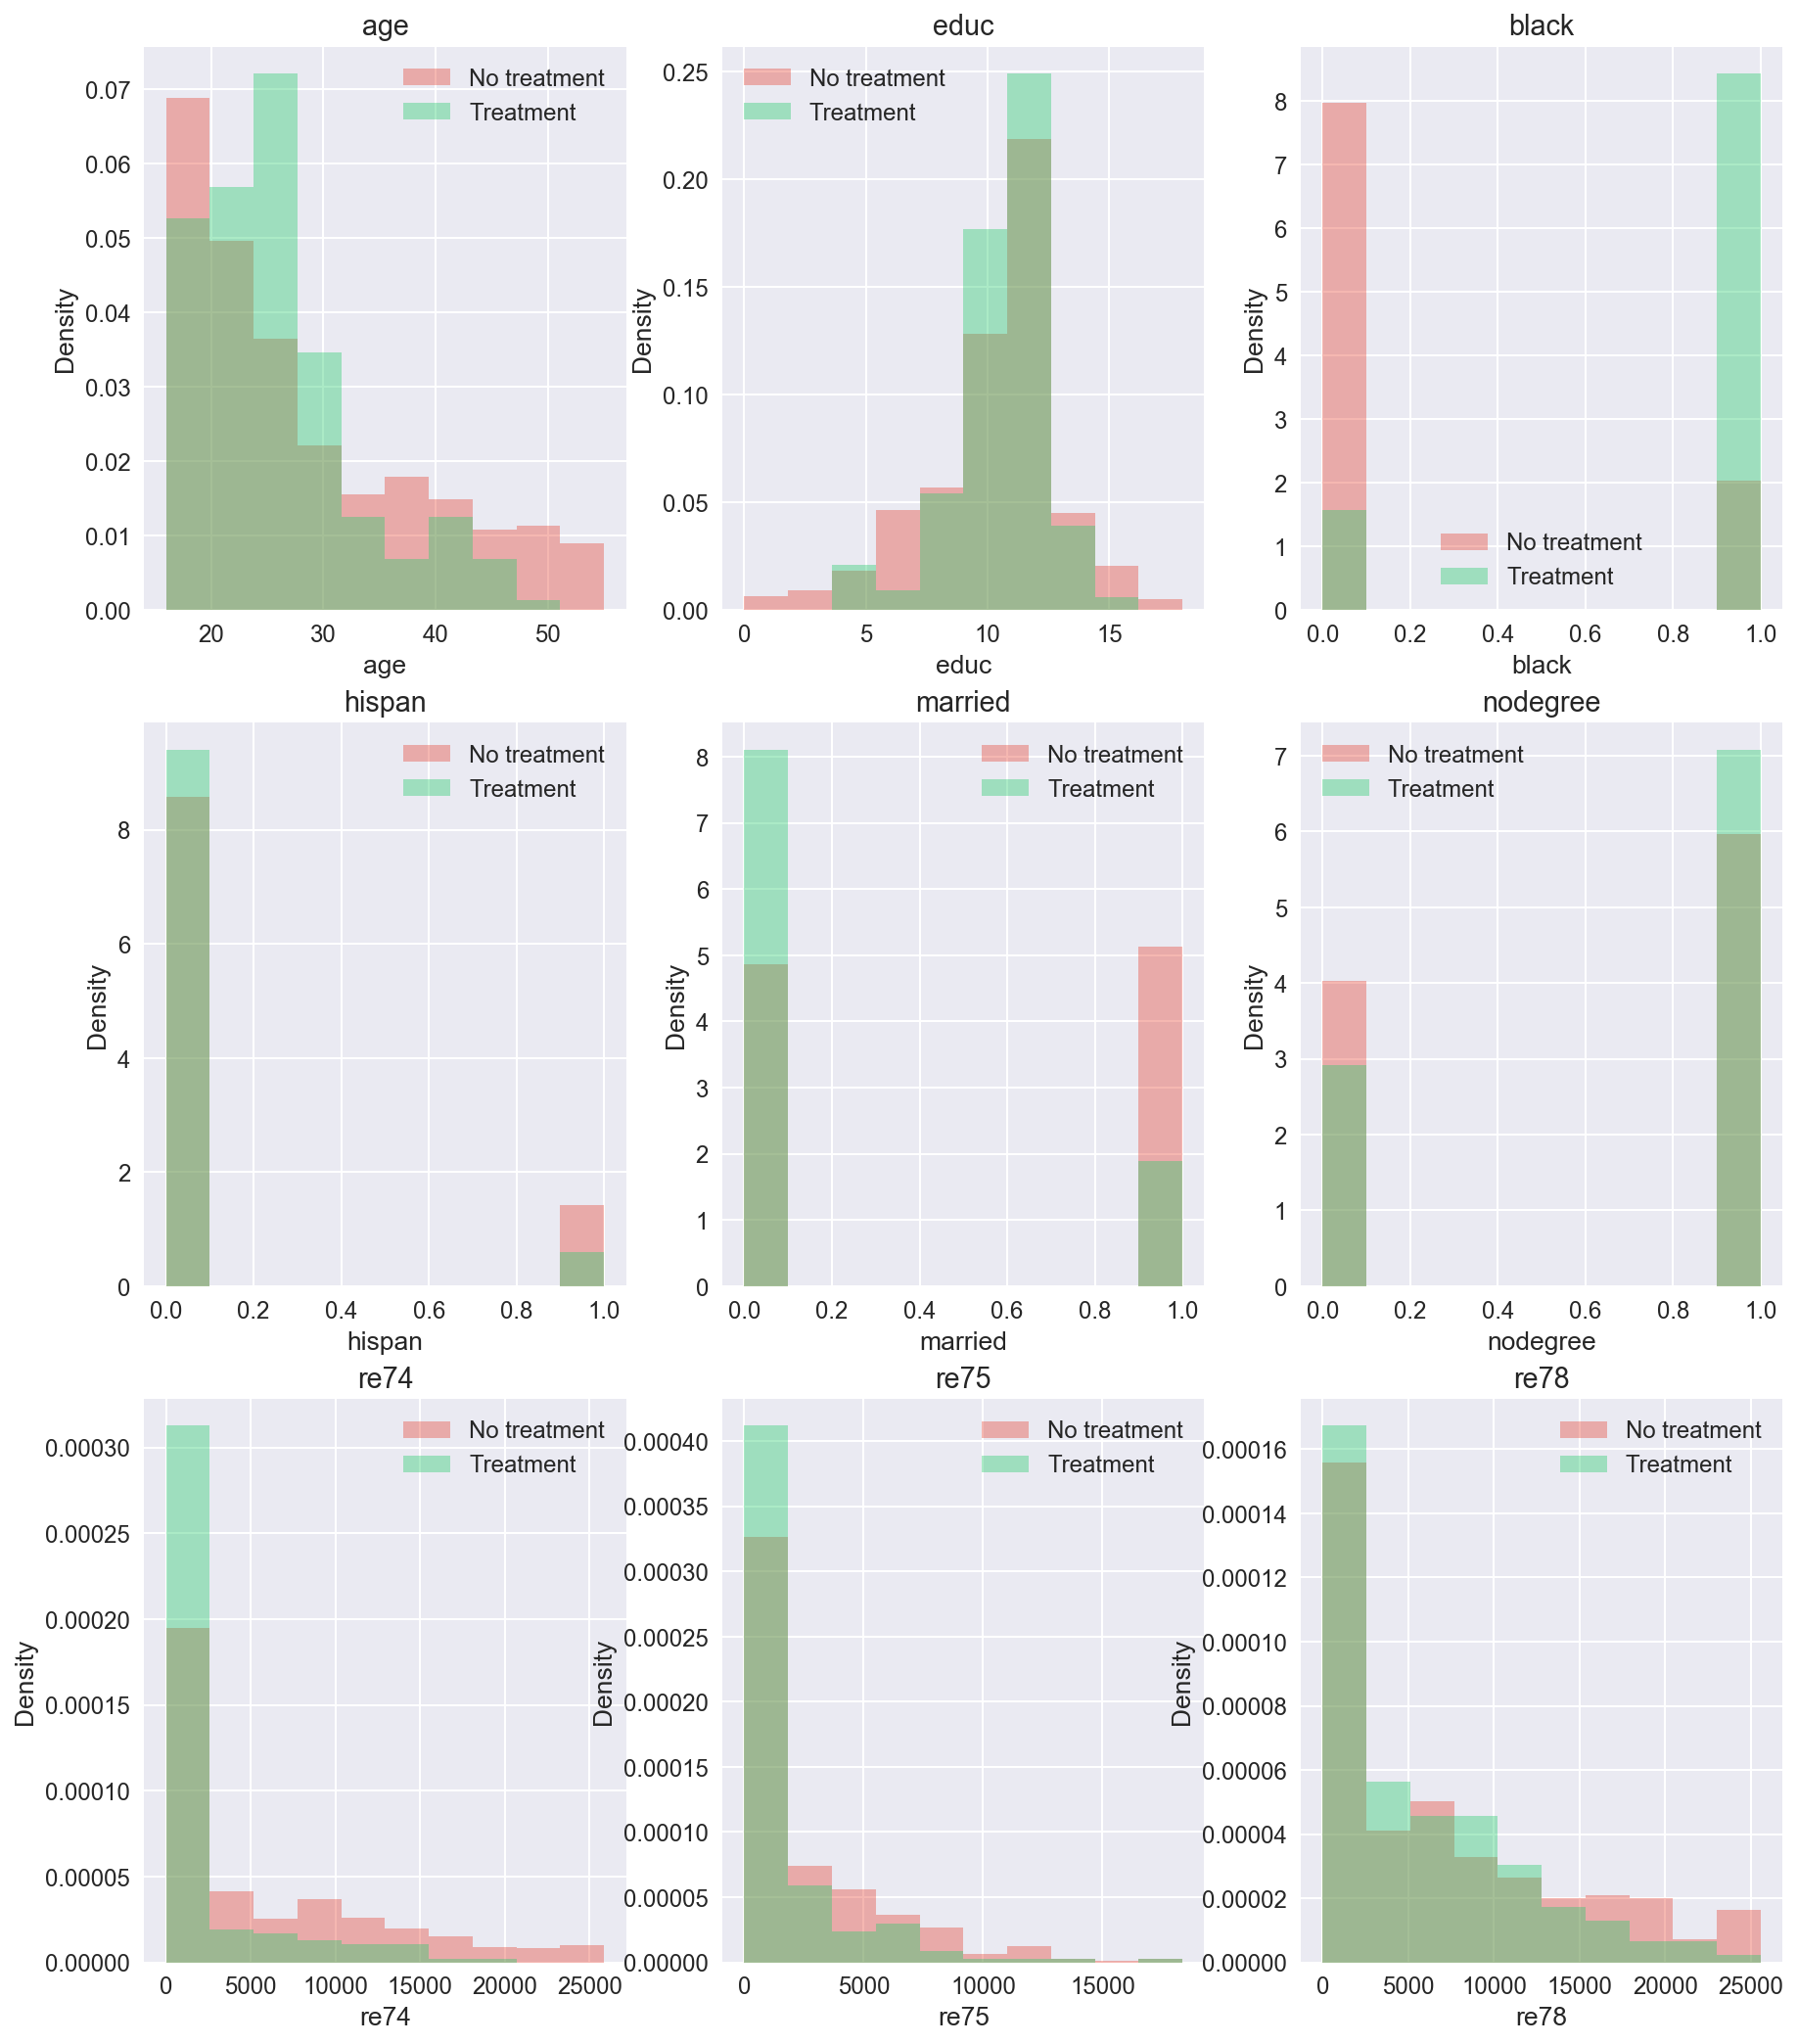

In [57]:
#let's plot all the distribs
f, axarr = plt.subplots(3, 3, figsize=(15, 18))
for index, feature in enumerate(['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']):
    ax = axarr[int(index/3)][index%3]
    plot_distrib(s1=lalonde[feature][lalonde['treat'] == 0], s2=lalonde[feature][lalonde['treat'] == 1], title=feature, xLabel = feature, yLabel='Density', ax=ax)

Here we plot all the distributions. If we want our analysis not to be naive, these distributions should be almost the same along the two categories (treated and not treated).

We can already spot some huge differences between the distributions from these plots (Features `black` and `married` for example) but some Kolmogorov–Smirnov 2 sample tests will help us be sure of our analysis.

Recall the definition of a Kolmogorov–Smirnov 2 sample test:

The Kolmogorov–Smirnov 2 sample test tests whether 2 samples are drawn from the same distribution. If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [58]:
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
for feature in ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']: 
    ks = stats.ks_2samp(lalonde[feature][lalonde['treat'] == 0], lalonde[feature][lalonde['treat'] == 1]) 
    print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

age        0.158       0.003
educ       0.111       0.075
black      0.640       0.000
hispan     0.083       0.326
married    0.324       0.000
nodegree   0.111       0.075
re74       0.447       0.000
re75       0.288       0.000
re78       0.099       0.153


Note that the values are rounded, of course the p-values are not exactly equal to 0, but they are very small (way below 0.05 for example).

Let's take the usual threshold of 0.05 for the p-value analysis. We can therefore reject the null hypothesis for the following features :

- `age`
- `black`
- `married`
- `re74`
- `re75`

For the other features, we can not reject the null hypothesis that the two samples are from the same distributions.

The analysis of the p-values confirms the one from the plots: the distributions are very different for the treated and the non treated population. This confirms that the analysis we had in part 1 is naive. 

As seen in class, a propensity score matching can help us equilibrate these distributions and have a less naive analysis.

### Pairwise analysis of features' distribution

The following plot will help us understand how the features are linked to each others. This pairplot helped us greatly in the understanding of the different distributions when looking at two features at the same time.

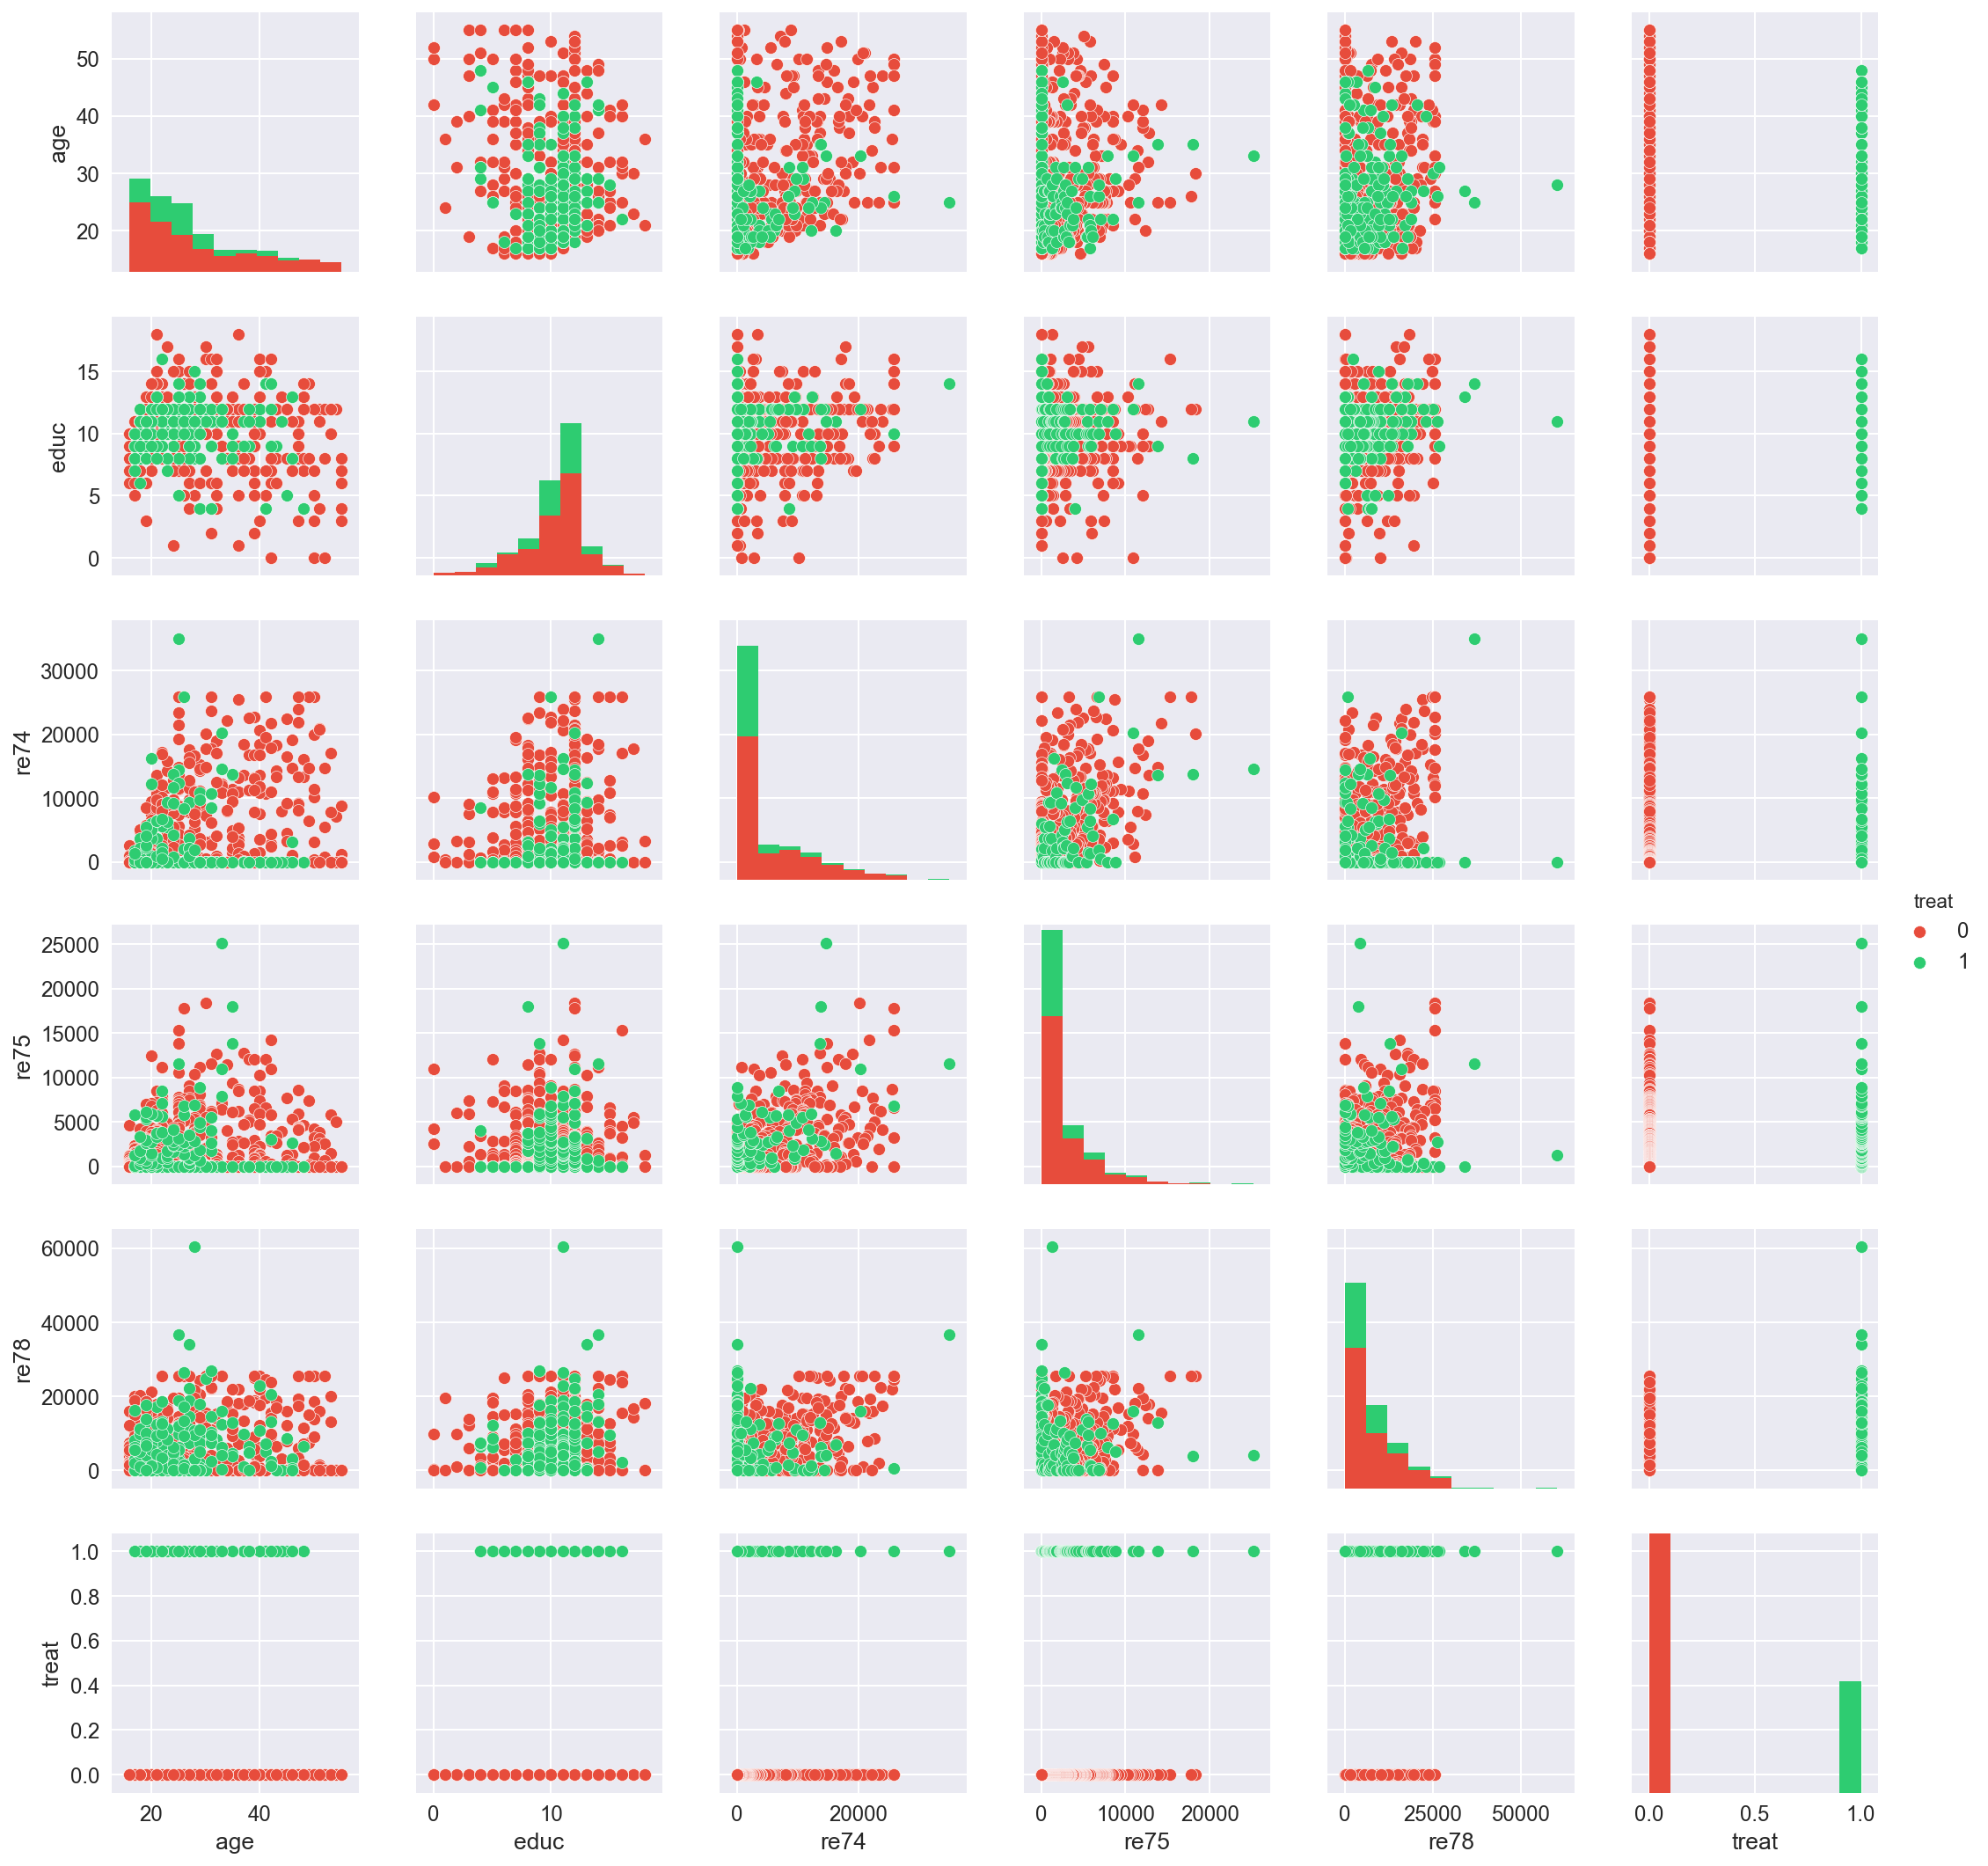

In [59]:
#This pairplot allows us to analyse the distribution on pair of features for the two populations
sns.pairplot(lalonde_non_cat, hue='treat', palette={0:"#e74c3c", 1: "#2ecc71"})

We will be succinct in our conclusions as this analysis is not asked in the homework.

The main conclusions that araise from these plots is that the distributions of the non treated populations on all the features are way more widespread than the ones for the treated population. The tails are way heavier in all the cases.

This reinforce the sentiment that a matching across the individuals will reduce these differences.

## 3. A propsensity score model

We should fit our model on the pre treatment features, though we will have to remove the `re78` feature.
Furthermore, we preprocess our data by standardizing them so we don't have some features that have more importance than some others.

With the help of a logistic regression, the model will attribute a percentage of how much it thinks an individual has the attribute `treat=1`.

In [60]:
import sklearn.linear_model
#removing the useless features
lal = lalonde.drop(['id','treat','re78'],1)
#prepocess by standardizing the dataset
lal = preprocessing.scale(lal)
#Perform a logistic regression in order to get the propensity score for each individuals
model = sklearn.linear_model.LogisticRegression()
model.fit(lal, lalonde.treat)
pred = model.predict_proba(lal)

Here we check the performance of our model, we have an accuracy of 82% which is quite good for a very simple logistic regression.

In [61]:
#Check the performance of the model
sum(model.predict(lal) == lalonde.treat)/len(lal)

0.8241042345276873

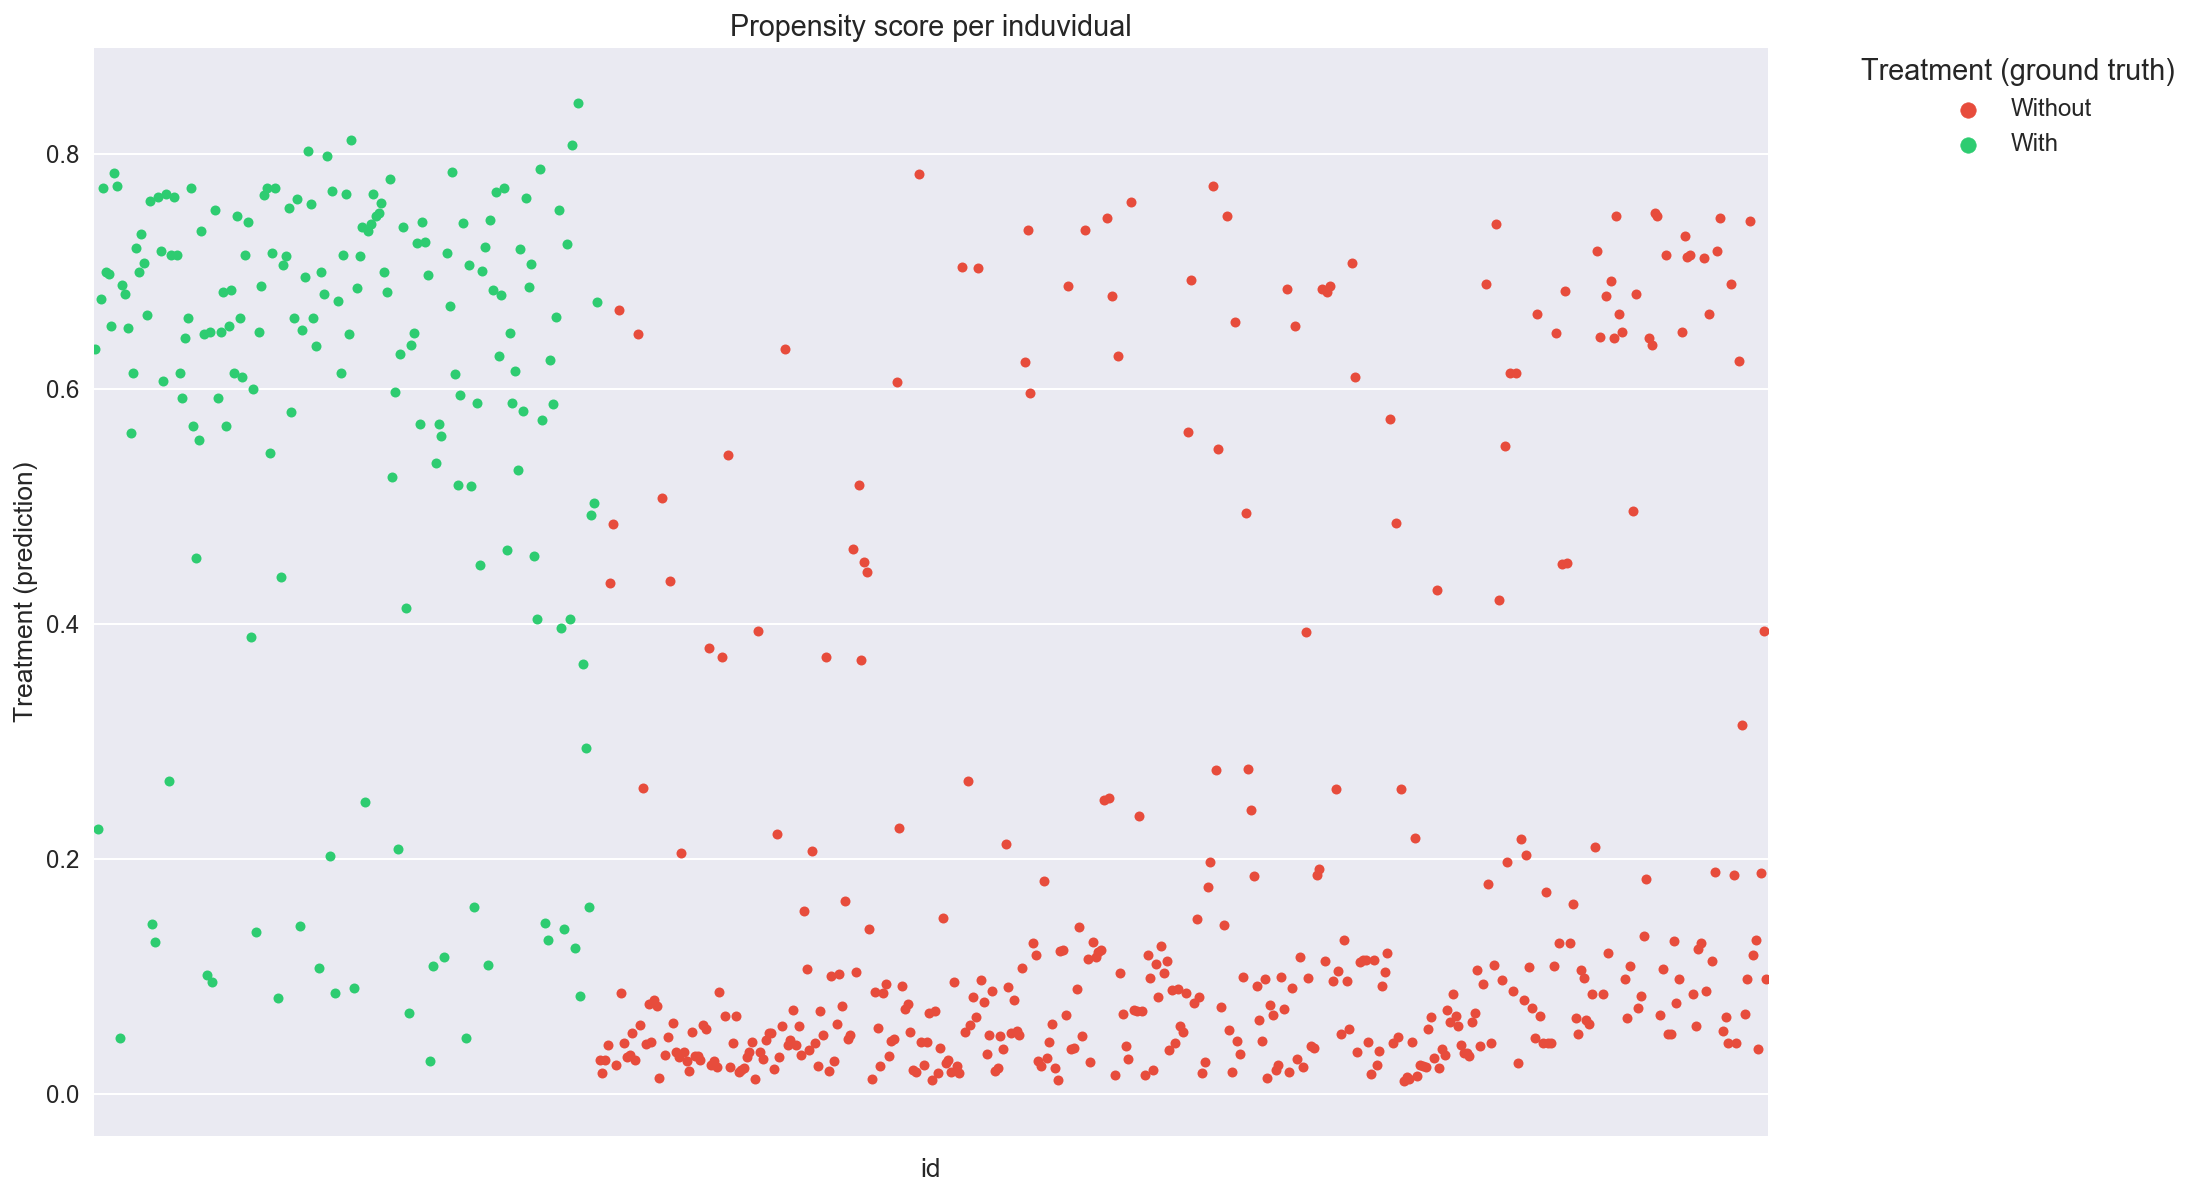

In [62]:
#Scatter plot of the propensity score
plt.figure(figsize=(15, 10))
lalonde['pred'] = pred[:,1]
ax = sns.stripplot(x='id', y='pred', hue='treat', data=lalonde, palette={0:"#e74c3c", 1: "#2ecc71"})
ax.set(xticklabels=[], ylabel='Treatment (prediction)')
plt.title('Propensity score per induvidual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=ax.get_legend_handles_labels()[0], labels=['Without', 'With'], title='Treatment (ground truth)')

This plot shows us what the propensity score for each individuals is. 
The individuals that received the treatment are in green and should have a score around 1 whereas the individuals that didn't receive it are in red and should have a score around 0. Even if we have some outliers, this is what we observe on the plot.

## 4. Balancing the dataset via matching
Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.

We saw in class that matching among the propensity score is almost the same as matching among the features.

In order to do this matching, we will procede in the following way:


- First, we will create a complete bipartite graph. It means that the vertices are partitioned into two subsets V1 (the people who received the training) and V2 (the people who did not receive the traing) such that no edge has both endpoints in the same subset, and every possible edge that could connect vertices in different subsets is part of the graph. This way will will be sure to match treated people with people without treatment

- We will give a weight to these edges: Let's take two individuals,we denote by $w_1$ the propensity score of the treated individual and $w_2$ the propensity score of the untreated individual. The weight of the edge between them will be:
$$W = - |w_{1} - w_{2}| $$

- Finally we will use a maximum weight matching with max cardinality algorithm. Note that we have a minus sign in our weights because we want to minimize the weights even though we are using a maximum weight matching algorithm. We are using the method implemented in the NetworkX package. This method is based on the “blossom” method for finding augmenting paths and the “primal-dual” method for finding a matching of maximum weight, you can read more about it there : https://dl.acm.org/citation.cfm?id=6502 .

In [63]:
import networkx as nx
from networkx.algorithms import bipartite

#create the nodes
G=nx.Graph()
G.add_nodes_from(lalonde['id'][lalonde.treat == 0])
G.add_nodes_from(lalonde['id'][lalonde.treat == 1])

In [64]:
#Bipartite complete graph
for ID_u, score_u in zip(lalonde.id[lalonde.treat == 0], lalonde.pred[lalonde.treat == 0]):
    for ID_v, score_v in zip(lalonde.id[lalonde.treat == 1], lalonde.pred[lalonde.treat == 1]):
        G.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))

In [65]:
#Let's check if the number of nodes and edges is right
#Number of nodes should be 185+429 = 614 (the graph is bipartite) and number of edges should be 185*429 = 79365
#because it is complete bipartite
print(G.number_of_nodes())
print(G.number_of_edges())

614
79365


In [66]:
#Here we compute the matching
from networkx.algorithms import max_weight_matching
matching = max_weight_matching(G, maxcardinality=True)

In [67]:
#Let's clean the result of our matching
res = dict()
for key in matching.keys():
    if(key[0] == 'N'):
        res[key] = matching[key]
print("The Length of our matching is:") 
print(len(res))

The Length of our matching is:
185


The matching is now computed, we have all of our treated individuals (185) matched with a non treated individual such that the absolute value of the difference of the propensity scores is minimal.
Let's now check the performance of this matching. In order to do that, we will sum the absolute value of the differences of propensity scores.

In [68]:
#Here we use a temp columm in order to merge the two datasets
lalonde_treated = lalonde[lalonde['treat'] == 1]
lalonde_treated['temp'] = 1
lalonde_nt = lalonde[lalonde['treat'] == 0]
lalonde_nt['temp'] = 1

#We merge the two datasets thanks to the temp column, this new merged dataset mimics the complete bipartite graph:
result = pd.merge(lalonde_treated, lalonde_nt, on='temp')
result = result[['id_x' , 'id_y' , 'pred_x' , 'pred_y']]
result['diff'] = abs(result['pred_x'] - result['pred_y'])
result = result.set_index(['id_x', 'id_y'])
#Now let's sum over the pairs that are matched thanks to loc items that are in the dic of the matching
print('Sum of the difference of propensity score among matched individuals:' )
print(sum(result.loc[list(res.items())]['diff']))
print('Average of the difference of propensity score among matched individuals:' )
print(sum(result.loc[list(res.items())]['diff'])/len(result.loc[list(res.items())]))

Sum of the difference of propensity score among matched individuals:
39.15286960538312
Average of the difference of propensity score among matched individuals:
0.2116371330020709


39.15 is the score of our matching over the 185 individuals. The mean of the absolute value of the difference between propensity score is 0.21.

Let's compare the revenue in 78 between these two matched groups. We hope to have better results than the ones we had for the naive analysis.
Below, you can see how the matching looks like.

In [69]:
#Here you can have a look at the matched individuals and their propensity scores.
#The diff colum is the absolute value of the difference
result.loc[list(res.items())].head()

,,pred_x,pred_y,diff
id_x,id_y,,,
NSW105,PSID388,0.749435,0.749435,0.0
NSW104,PSID374,0.746683,0.746683,0.0
NSW92,PSID392,0.714055,0.714055,0.0
NSW61,PSID376,0.648554,0.648554,0.0
NSW56,PSID401,0.714055,0.714055,0.0


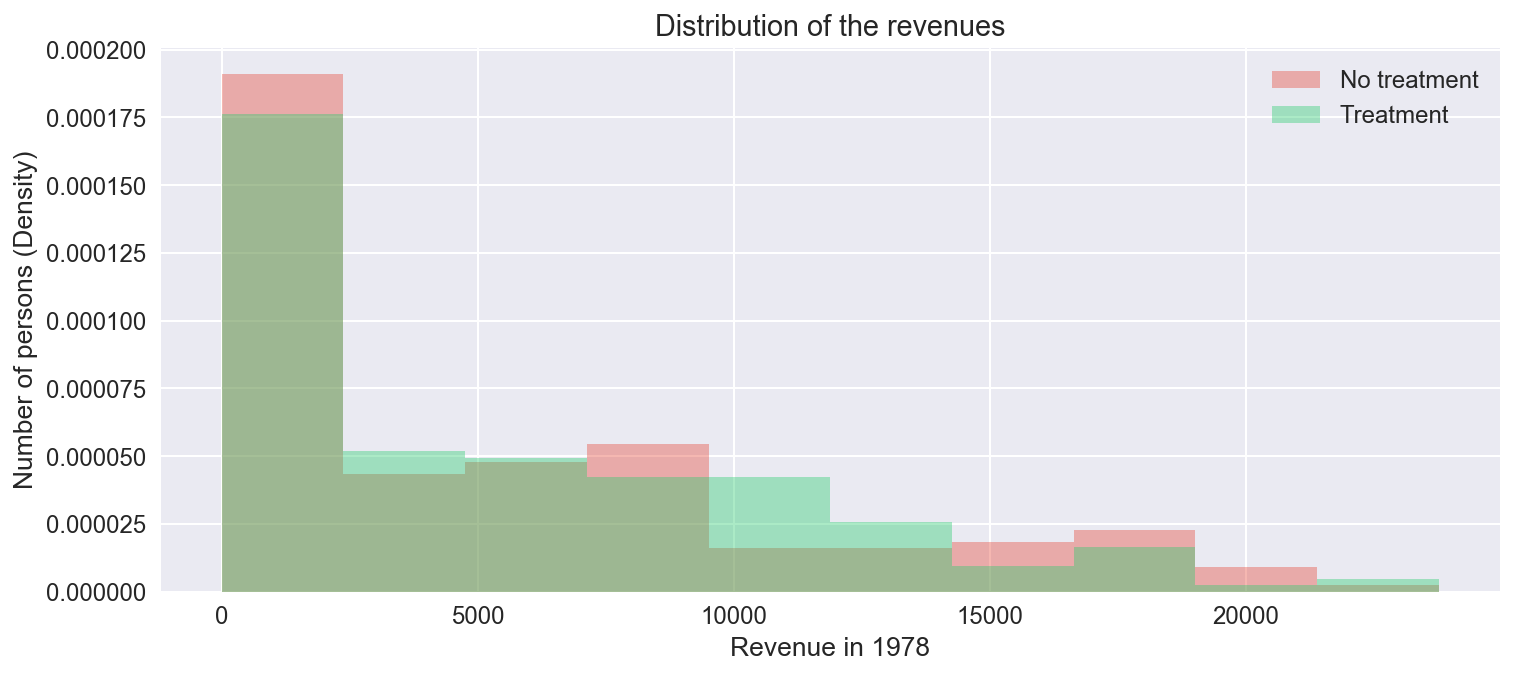

In [70]:
#Let's plot the distributions for the matching
lalondeid = lalonde.set_index('id')
matched = lalondeid.loc[list(matching.keys())]
plt.figure(figsize=(12,5))
plot_distrib(s1=matched.re78[matched['treat'] == 0], s2=matched.re78[matched['treat'] == 1], 
             title='Distribution of the revenues', ax=None, xLabel='Revenue in 1978', yLabel='Number of persons (Density)')

In [71]:
#Kolmogorov-smirnoff for the matching on re78
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 're78'
ks = stats.ks_2samp(matched[feature][matched['treat'] == 0], matched[feature][matched['treat'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

re78       0.081       0.560


When looking at the plot, the distributions seem more alike. It looks like the distribution of the revenues is more fair across the two populations (treated vs non treated).

The p-value is higher than it was during the naive analysis (still way above the usual threshold of 0.05), therefore we still can't reject the null hypothesis that says that the distributions of the two samples are the same.

Now, let's observe how the other indicators we checked during part 1 changed with the matching.

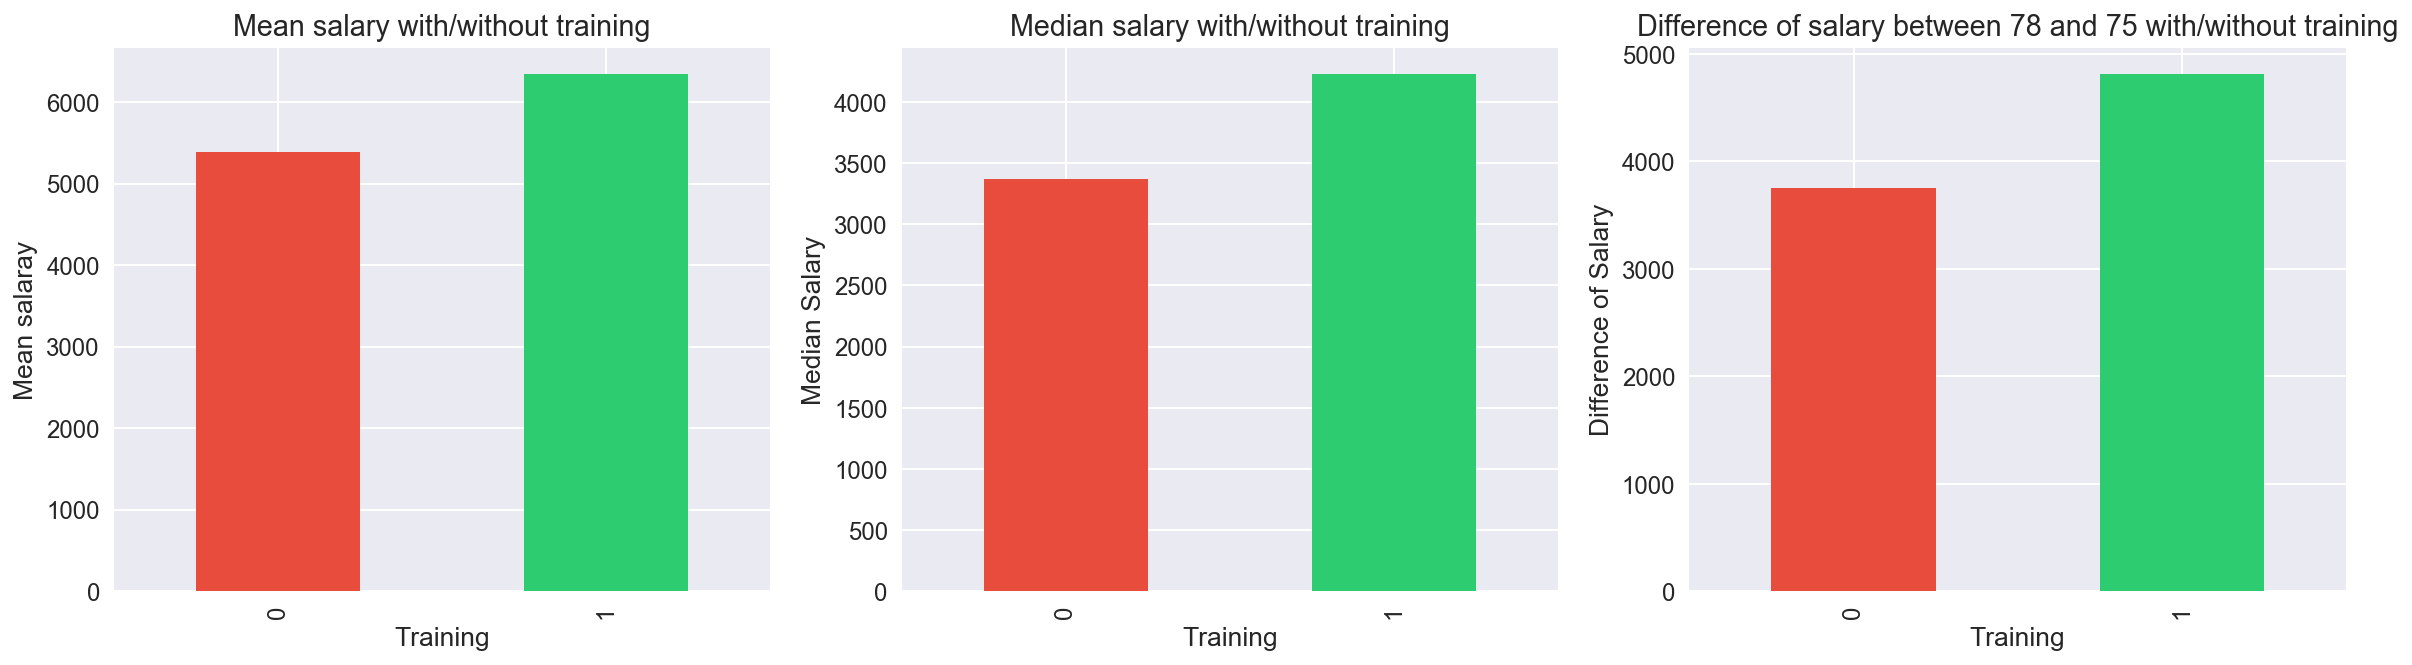

In [72]:
matched['diff'] = matched['re78'] - matched['re75']


#Plot of the indicators with the matched individuals
plt.figure(figsize=(20,5))
plt.subplot(131)
matched.groupby(['treat'])['re78'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Mean salary with/without training')
plt.ylabel('Mean salaray')
plt.xlabel('Training')
plt.subplot(132)
matched.groupby(['treat'])['re78'].median().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Median salary with/without training')
plt.ylabel('Median Salary')
plt.xlabel('Training')
plt.subplot(133)
matched.groupby(['treat'])['diff'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Difference of salary between 78 and 75 with/without training')
plt.ylabel('Difference of Salary')
plt.xlabel('Training')

matched = matched.drop('diff',1)

The conclusion here is totally different from the one we had with the naive analysis.

Indeed, all of the indicators are now better for the population that took part in the training. This shows that the naive analysis was biased.

A training that seemed useless with a naive analysis now seems to be quite effective. Indeed people that benefits from it are doing better than people who did not.

But is our analysis the best now? Let's check what are the distributions of the other features. For our analysis to be the best, we expect them to be almost equal across the two populations (treated and non treated).

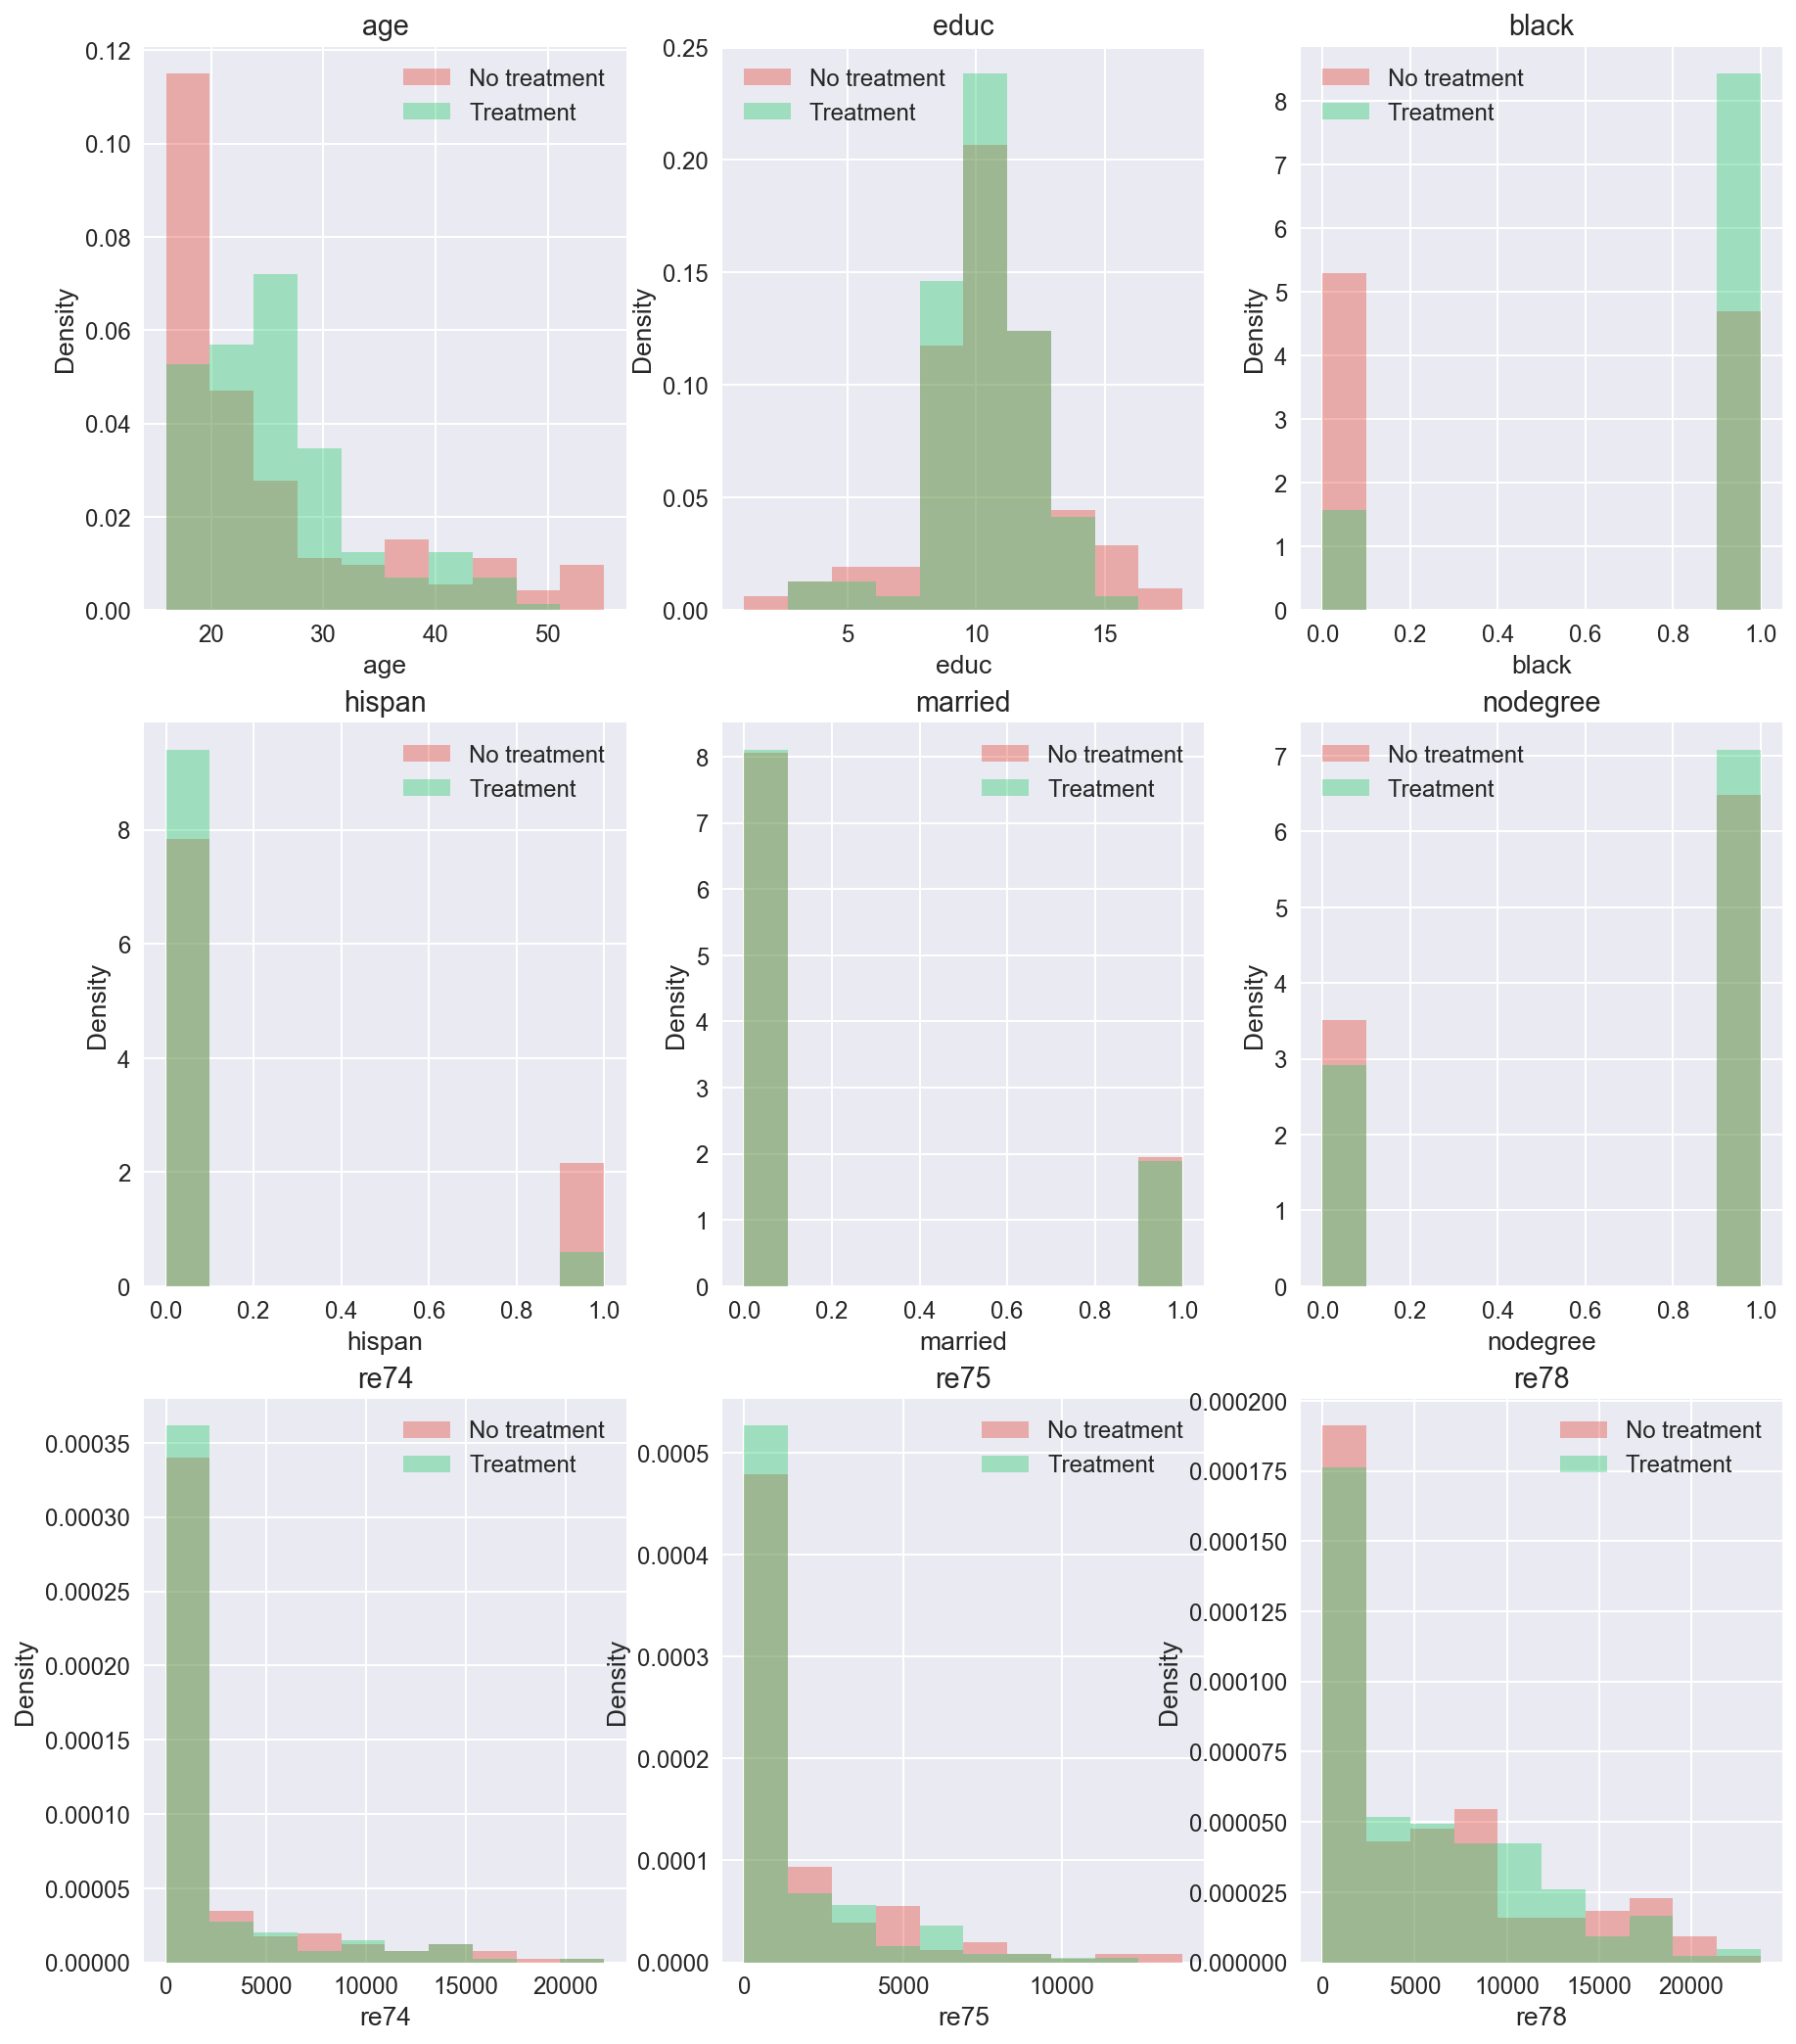

In [73]:
f, axarr = plt.subplots(3, 3, figsize=(15, 18))
for index, feature in enumerate(['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']):
    ax = axarr[int(index/3)][index%3]
    plot_distrib(s1=matched[feature][matched['treat'] == 0], s2=matched[feature][matched['treat'] == 1], title=feature, xLabel = feature, yLabel='Density', ax=ax)

In [74]:
from scipy import stats 
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\\n') 
for feature in ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']: 
    ks = stats.ks_2samp(matched[feature][matched['treat'] == 0], matched[feature][matched['treat'] == 1]) 
    print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value \n
age        0.270       0.000
educ       0.065       0.819
black      0.373       0.000
hispan     0.157       0.019
married    0.005       1.000
nodegree   0.059       0.890
re74       0.292       0.000
re75       0.216       0.000
re78       0.081       0.560


Let's observe how the features are distributed with the matching. 

When looking at the plots, we see that the distributions of the `age`, `black` and `hispan` features seem to very different across the two populations. 

Looking at the p-values, we can reject the null hypothesis for the following features:

- `age`
- `black`
- `re74`
- `re75`

Looking at the p-values, we cannot reject the null hypothesis for the `hispan` feature even if the distributions look different on the plot.
The distribution for the `married` feature that was very different in the naive analysis is now almost the same for the two samples with a p-value of 1.000.

The `black` feature is the most problematic and quite easy to balance thanks to it being categorical. In the next part we will balance it in a better way.

## 5. Balancing the groups further

We saw at the end of part 4 that we need to balance the classes in a better way. The most problematic feature is the categorical `black` feature.

Our idea to balance it is to redo a min weight matching as in part 4, only this time we will have more constraints.

In part 4 the only constraint was to match an individual with `treat=0` with an individual with `treat=1` and then optimize to have the minimum weight.

Now what we want to do is to match: 

- individuals with `treat=0` `black=0` with individuals with `treat=1` `black=0`
- individuals with `treat=0` `black=1` with individuals with `treat=1` `black=1`

This way we will force the distribution of the feature `black` to be equal across the two classes.

In order to do so, we will create a bipartite graph like in part 4 but this time it will not be complete. Indeed, we will only have edges according to the two points above. Then we will use the same method of max weight matching as we used earlier (with the minus sign on the weight because we want it to be minimize).

Note that by adding more constraints, not all the 185 treated individuals might be matched (there is not enough people with those caracteristics in the two populations treated/ not treated) but the distribution of the `black` feature will now be equal for treated and non treated individuals. We think this will result in a matching with a better 'score' than the previous one and the mean of the absolute value of the difference between propensity score among our matched individuals might be better as well.

In [75]:
#Create the new graph as described above
Gprime=nx.Graph()
Gprime.add_nodes_from(lalonde['id'][lalonde.treat == 0])
Gprime.add_nodes_from(lalonde['id'][lalonde.treat == 1])

#adding edges between the black=0 individuals
lalonde_not_black = lalonde[lalonde.black == 0]
for ID_u, score_u in zip(lalonde_not_black.id[lalonde_not_black.treat == 0], lalonde_not_black.pred[lalonde_not_black.treat == 0]):
    for ID_v, score_v in zip(lalonde_not_black.id[lalonde_not_black.treat == 1], lalonde_not_black.pred[lalonde_not_black.treat == 1]):
        Gprime.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))

#adding edges between the black=0 individuals
lalonde_black = lalonde[lalonde.black == 1]
for ID_u, score_u in zip(lalonde_black.id[lalonde_black.treat == 0], lalonde_black.pred[lalonde_black.treat == 0]):
    for ID_v, score_v in zip(lalonde_black.id[lalonde_black.treat == 1], lalonde_black.pred[lalonde_black.treat == 1]):
        Gprime.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))

In [76]:
#computing the matching
matching = max_weight_matching(Gprime, maxcardinality=True)
#Let's clean the matching a bit
res = dict()
for key in matching.keys():
    if(key[0] == 'N'):
        res[key] = matching[key]
print("The Length of our matching is:") 
print(len(res))

The Length of our matching is:
116


We observe that the lenght of our matching is now 116. This means that as expected, we don't have all the 185 individuals that can be matched according to our new constraints. 

This still reprensents $\dfrac{2}{3}$ of the treated individuals so we think the analysis is still relevant. 

Now let's observe the score of our matching and what is the average of the difference of propensity scores.

In [77]:
#Here we use a temp columm in order to merge the two datasets
lalonde_treated = lalonde[lalonde['treat'] == 1]
lalonde_treated['temp'] = 1
lalonde_nt = lalonde[lalonde['treat'] == 0]
lalonde_nt['temp'] = 1

#We merge the two datasets thanks to the temp column, this new merged dataset mimics the complete bipartite graph:
result = pd.merge(lalonde_treated, lalonde_nt, on='temp')
result = result[['id_x' , 'id_y' , 'pred_x' , 'pred_y']]
result['diff'] = abs(result['pred_x'] - result['pred_y'])
result = result.set_index(['id_x', 'id_y'])
result
#Now let's sum over the pairs that are matched thanks to loc items that are in the dic of the matching
print('Sum of the difference of propensity score among matched individuals:' )
print(sum(result.loc[list(res.items())]['diff']))
print('Average of the difference of propensity score among matched individuals:' )
print(sum(result.loc[list(res.items())]['diff'])/len(result.loc[list(res.items())]))

Sum of the difference of propensity score among matched individuals:
1.0991572964964065
Average of the difference of propensity score among matched individuals:
0.009475493935313849


The score is indeed way better than what it was for the first matching. Note that the average value of the difference is only of 0.009, the individuals that are matched now have almost the same propensity score.

We are very satisfied of this new constraint we added as we only 'lost' $\dfrac{1}{3}$ of the treated population but now have a very good propensity score matching. We don't think we need to add more constraints as we would lose more people for almost no improvement in the matching.

In [78]:
#Here you can have a look at the matched individuals and their propensity scores.
#The diff colum is the absolute value of the difference
result.loc[list(res.items())].head()

,,pred_x,pred_y,diff
id_x,id_y,,,
NSW105,PSID388,0.749435,0.749435,0.0
NSW104,PSID374,0.746683,0.746683,0.0
NSW92,PSID392,0.714055,0.714055,0.0
NSW61,PSID376,0.648554,0.648554,0.0
NSW56,PSID401,0.714055,0.714055,0.0


Let's observe how the distributions of the features look like with this new matching:

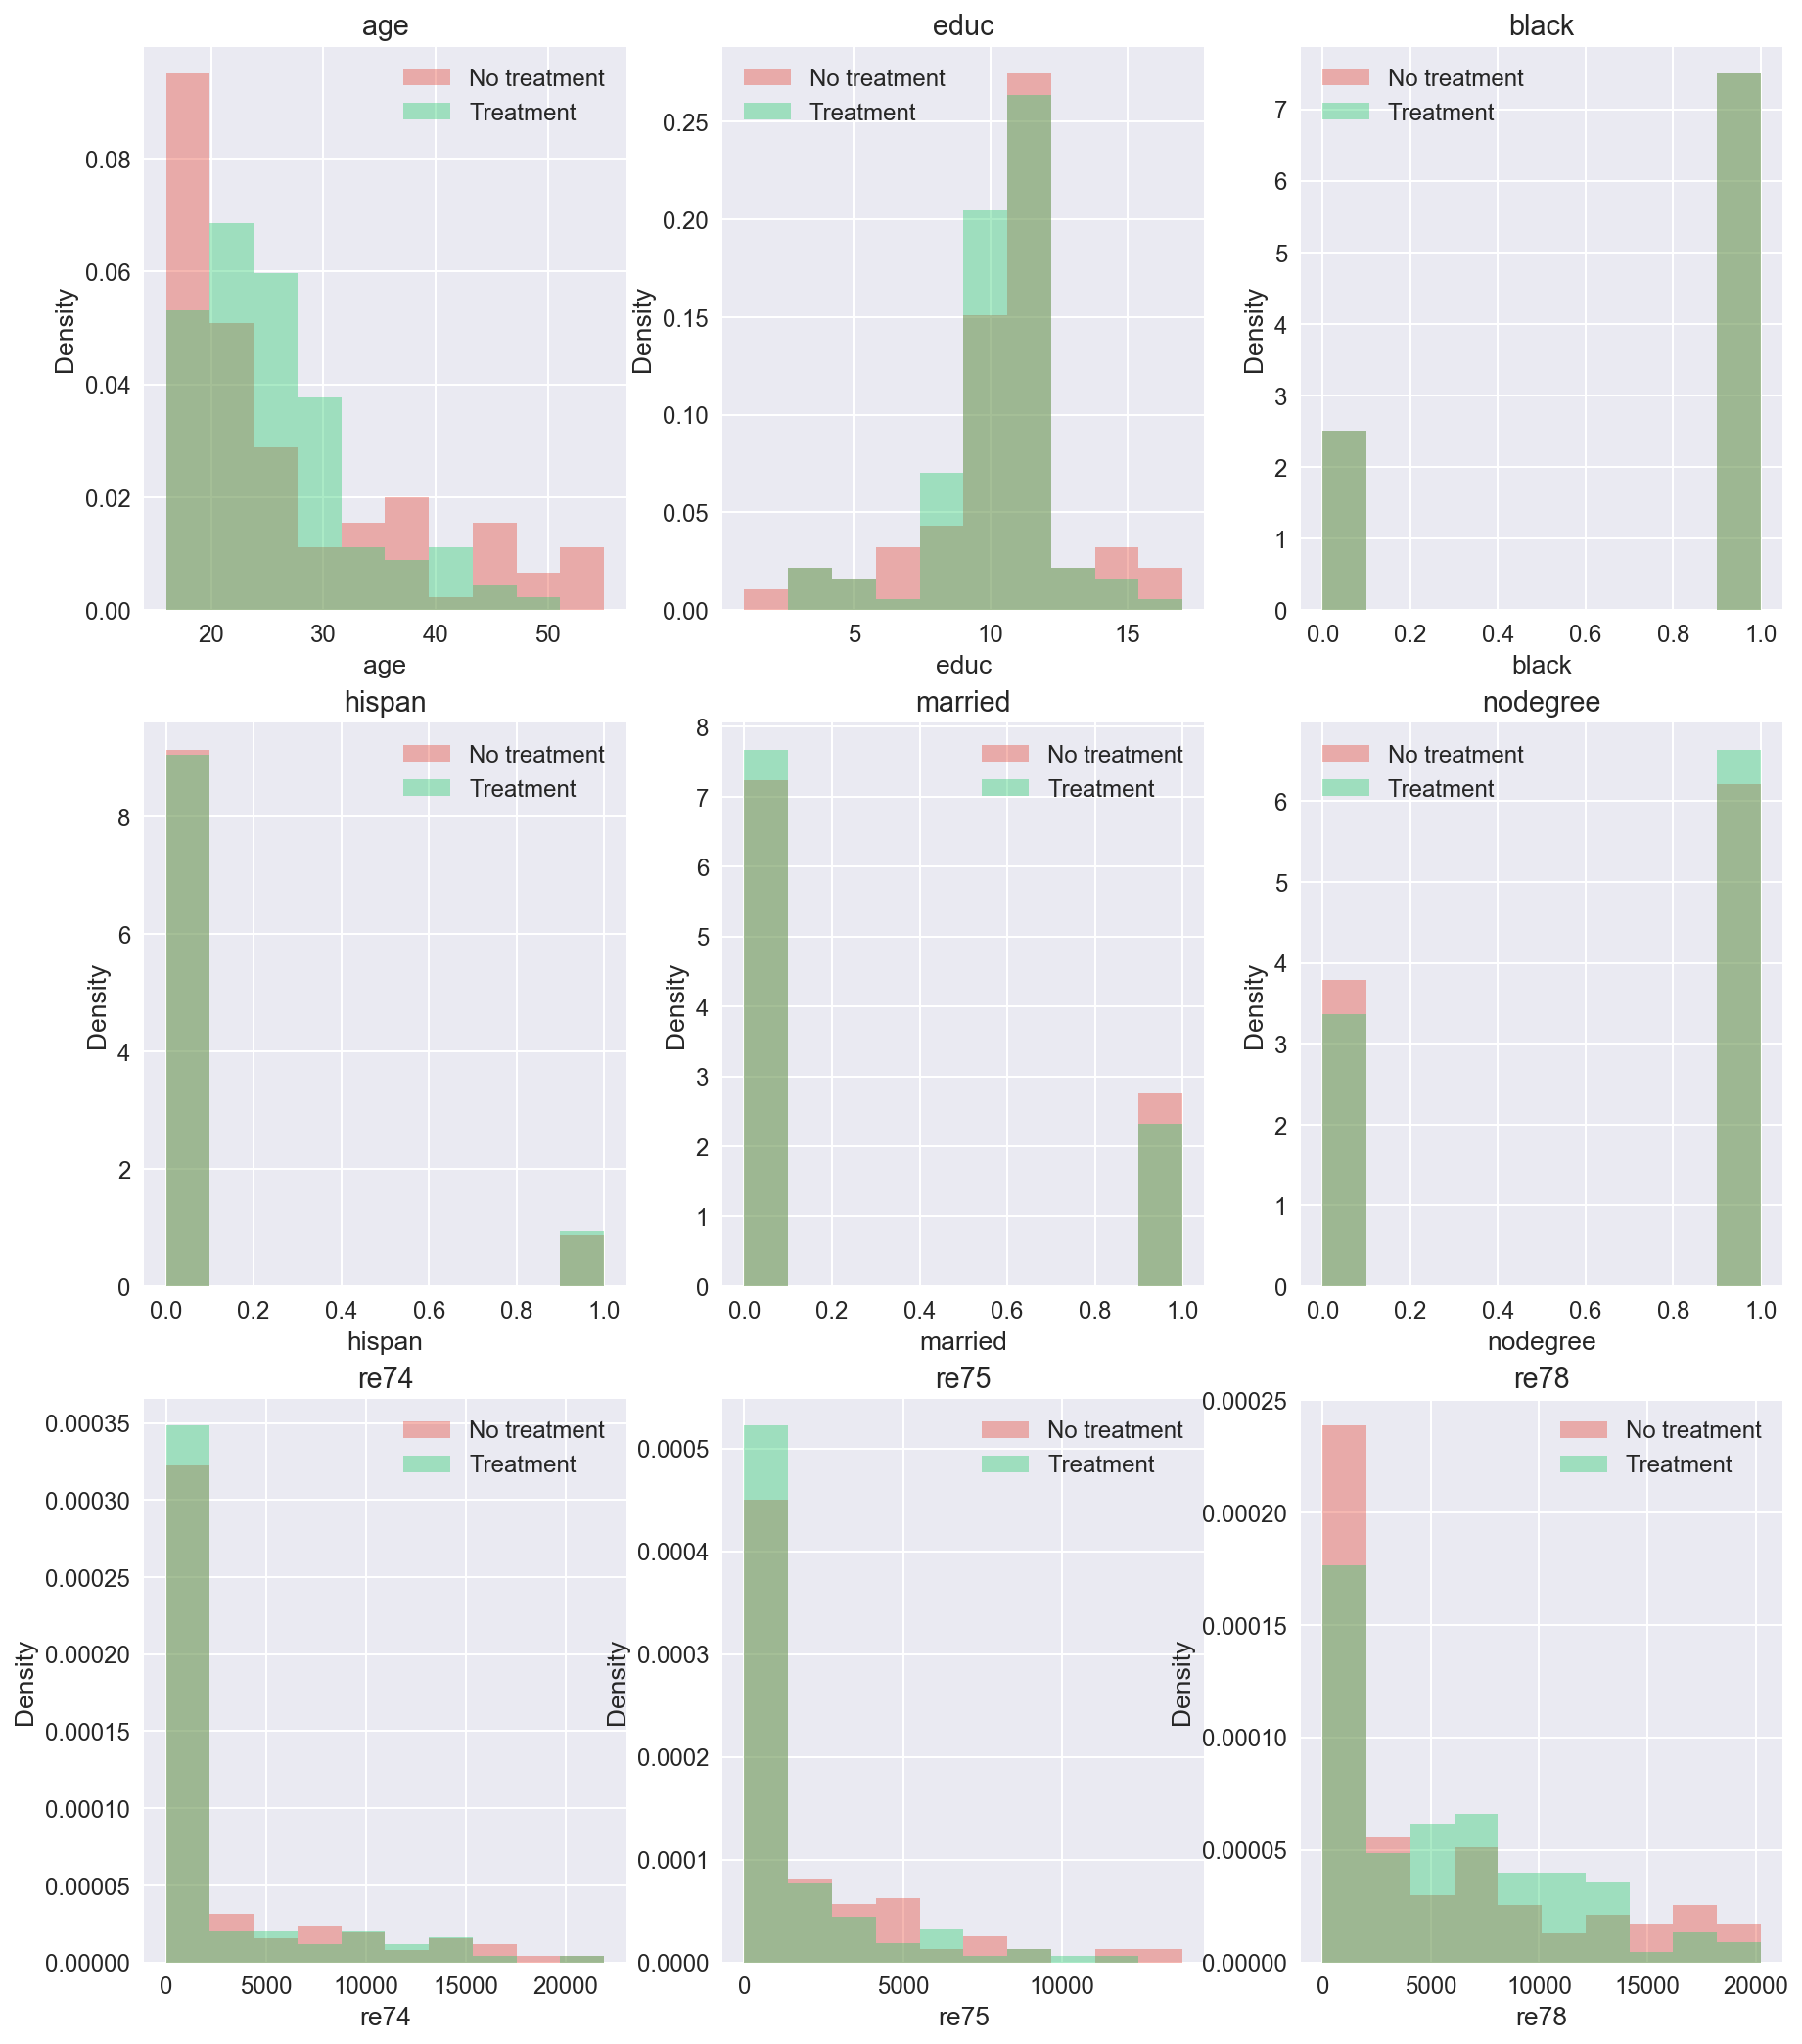

In [79]:
#Let's observe how the distributions look like

#Select the individuals that are matched
lalonde.set_index('id' , inplace = True)
matched = lalonde.loc[list(matching.keys())]

#plot the distrib among the matched individuals
f, axarr = plt.subplots(3, 3, figsize=(15, 18))
for index, feature in enumerate(['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']):
    ax = axarr[int(index/3)][index%3]
    plot_distrib(s1=matched[feature][matched['treat'] == 0], s2=matched[feature][matched['treat'] == 1], title=feature, xLabel = feature, yLabel='Density', ax=ax)

In [80]:
from scipy import stats
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n')
for feature in ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']:
    ks = stats.ks_2samp(matched[feature][matched['treat'] == 0], matched[feature][matched['treat'] == 1])
    print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

age        0.198       0.018
educ       0.069       0.938
black      0.000       1.000
hispan     0.009       1.000
married    0.043       1.000
nodegree   0.043       1.000
re74       0.284       0.000
re75       0.155       0.111
re78       0.181       0.039


Looking at the plots and the p-values, the distributions seem to be way more equal for both populations than what they were with the first matching. 

Indeed, the two distributions for `black` are now forced to be equals.  This feature now has a p-value of 1 for the Kolmogorov-Smirnov test.

Note that the features `educ`, `hispan`, `married` and `nodegree` also have a p-value of 1 or close to 1 with this matching. Therefore we cannot reject the null hypothesis that is: the two distributions are equal across the treated and non treated populations.
The p-value for `age` is 0.018, this is above the threshold of 0.05 that is usualy taken so we can not reject the null hypothesis. The same conclusions goes for `re75` which has a p-value of 0.111.

The only distribution for which we reject the null hypothesis is `re74` because it has a very low p-value. 

This matching seems to be very satisfying, let's analyse the conclusion for the `re78` feature and the indicators we defined.

## 6. A less naive analysis

We will now conclude the analysis by comparing the revenues in 1978 for the individuals matched in 1.5 and compare it with the naive analysis we had in part 1.

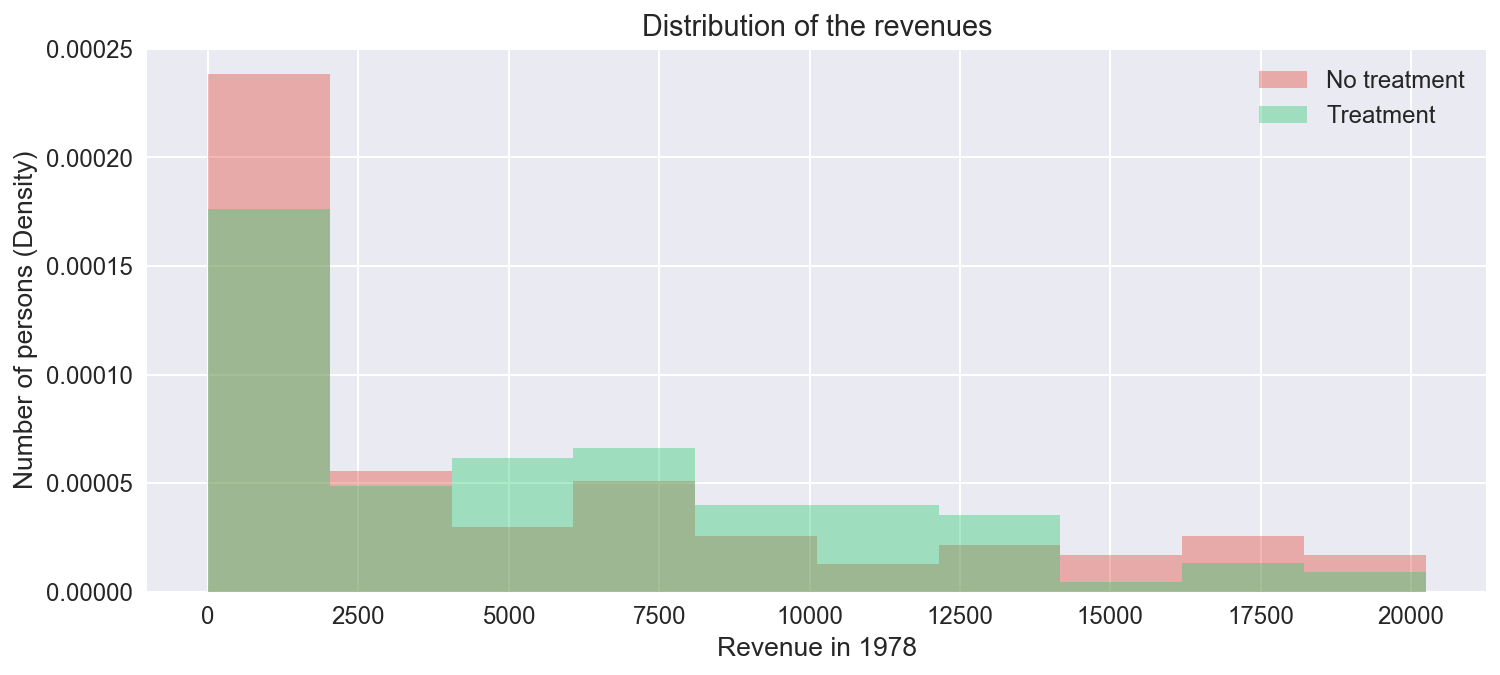

In [81]:
#Let's plot the distributions for the 'forced' the matching
plt.figure(figsize=(12,5))
plot_distrib(s1=matched.re78[matched['treat'] == 0], s2=matched.re78[matched['treat'] == 1], 
             title='Distribution of the revenues', ax=None, xLabel='Revenue in 1978', yLabel='Number of persons (Density)')

As we can see on the plot, it looks that the concentration of people that did not receive the treatment is more on the tails. The people who received the treatment are more concentrated around the average values.

When comparing this to the plot we had in the naive analysis (remember that the people who received the training were concentrated on the left tail aka low salaries), we can say that the job training program seem to be effective! That was not our conclusion in the naive analysis.

In [82]:
#Kolmogorov-smirnoff for the matching on re78
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 're78'
ks = stats.ks_2samp(matched[feature][matched['treat'] == 0], matched[feature][matched['treat'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

re78       0.181       0.039


The p-value is high so we cannont reject the null hypothesis for the Kolmogorov-Smirnov test for two samples.
We could extrapolate this by saying that if the distributions for the treatment in not 'better' than the one without treatment, they at least seem to be equal.

Let's observe the other indicators we defined in part 1.

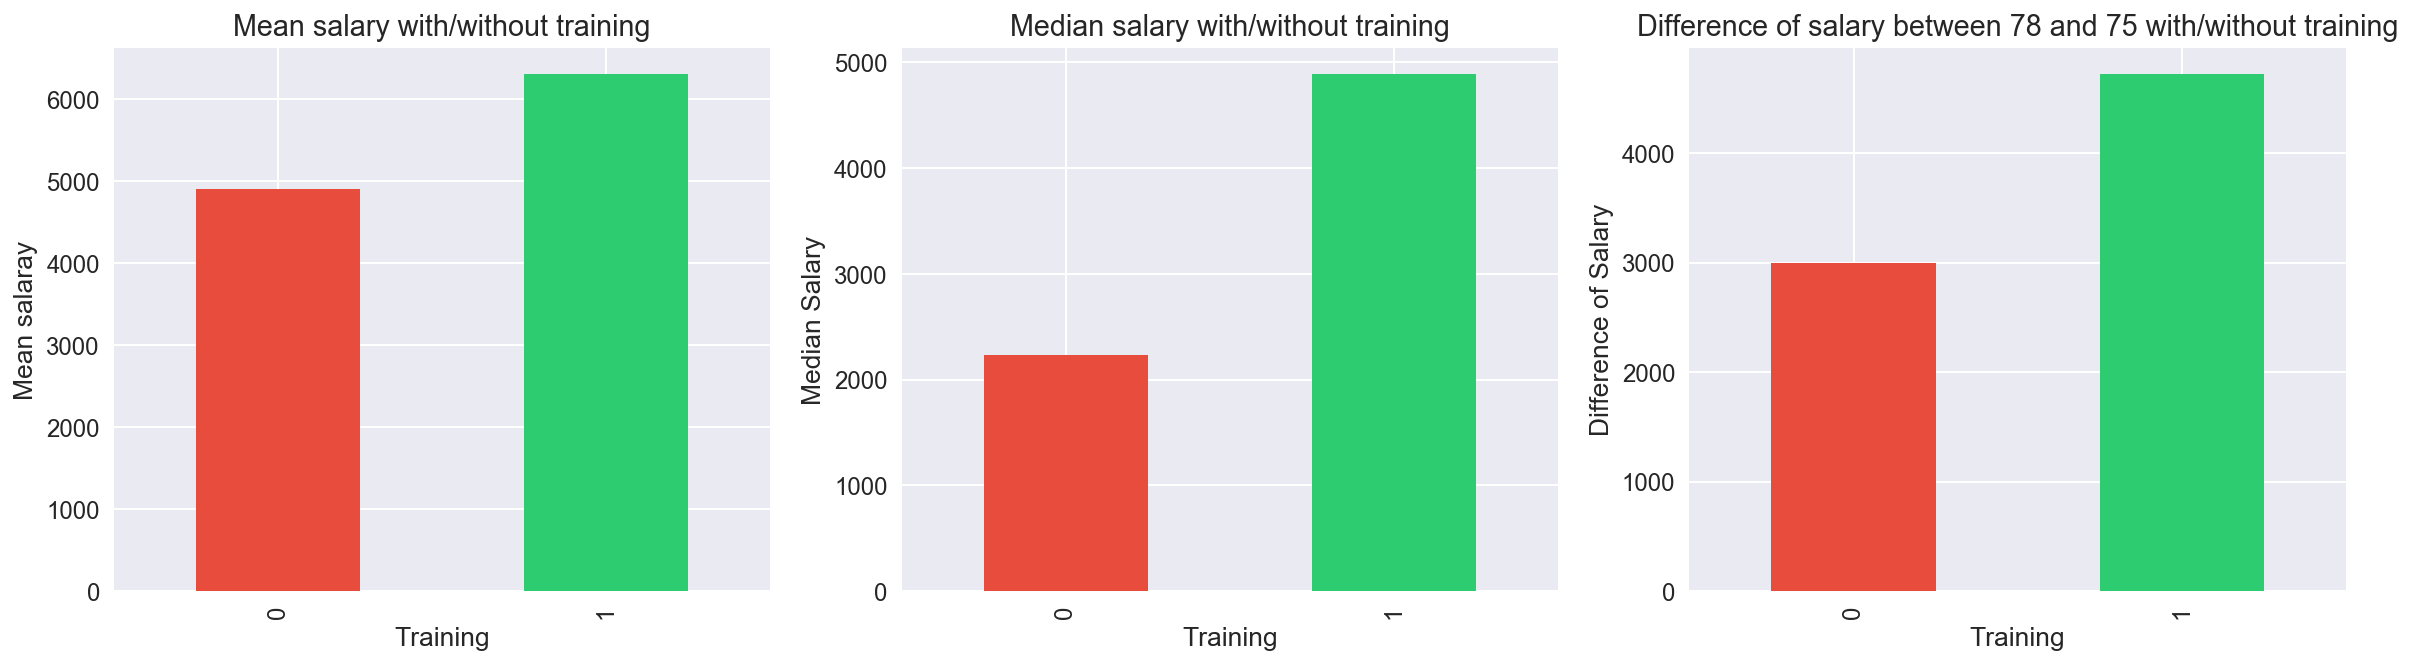

In [83]:
matched['diff'] = matched['re78'] - matched['re75']



plt.figure(figsize=(20,5))
axes = plt.subplot(131)
matched.groupby(['treat'])['re78'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Mean salary with/without training')
plt.ylabel('Mean salaray')
plt.xlabel('Training')
plt.subplot(132)
matched.groupby(['treat'])['re78'].median().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Median salary with/without training')
plt.ylabel('Median Salary')
plt.xlabel('Training')
plt.subplot(133)
matched.groupby(['treat'])['diff'].mean().plot.bar(color=[COLOR_NO_TREAT, COLOR_TREAT])
plt.title('Difference of salary between 78 and 75 with/without training')
plt.ylabel('Difference of Salary')
plt.xlabel('Training')

matched = matched.drop('diff',1)

Now it really seems that the job training program was effective.

- The mean salary for the people that received the training is more than $\$1000 $ higher compared to the average over the population that did not receive the training.

- The median salary is the two times higher for the population that received the training.

- People that received the training win almost $\$5000 $ more in avarerage when compared to what they used to earn in 1975. This number goes down to $ \$3000 $ for the population that did not receive the training.

# Question 2: Applied ML
We are going to build a classifier of news to directly assign them to 20 news categories.

- Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn. TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). **Compute TF-IDF features** for every article using TfidfVectorizer. Then, **split your dataset** into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

## 2.1.1 Loading the data

In [84]:
newsgroups = fetch_20newsgroups(subset='all')
print('Number of classes : %s'%(len(newsgroups.target_names)))
newsgroups.target_names

Number of classes : 20


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here are all the target names inside the newsgroup dataset. The dataset is composed of 20 classes. The classes are not equidistant: for example *alt.atheism* and *talk.religion.misc* are conceptually closer that *alt.atheism* and *rec.sport.hockey*. Hence, random forest tree classifier seems appropriate to discriminate data classes.
## 2.1.2 Vectorize and split data into training, validation and testing sets

In [85]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newsgroups.data)
print('There are %d news articles and %d features' %(np.shape(X)[0], np.shape(X)[1]))

There are 18846 news articles and 173762 features


Our dataset has 18846 datapoints and 173762 features. Now let split it into train, valid and test set. To do so, we created a function *get_train_valid_test_set* written in the box below.

In [86]:
def get_train_valid_test_set(data, labels, perc_for_valid, perc_for_test):
    '''
    returns the train, valid and test sets
    data : n x nb_features matrix
    perc_for_valid : value between 0 and 1 as the percentage of the dataset to be used in validation
    perc_for_test : value between 0 and 1 as the percentage of the dataset to be used in testing
    '''
    
    uindx = np.random.permutation(np.shape(data)[0])
    X_shuffled = data[uindx]
    labels_shf = labels[uindx]
    
    # take perc_for_test% of the dataset for testing
    X_test_shf = X_shuffled[:int(X_shuffled.shape[0]*perc_for_test)]
    y_test_shf = labels_shf[:int(X_shuffled.shape[0]*perc_for_test)]
    
    # take perc_for_valid% of the dataset for validation
    X_valid_shf = X_shuffled[int(X_shuffled.shape[0]*perc_for_test):
                             int(X_shuffled.shape[0]*(perc_for_test + perc_for_valid))]
    y_valid_shf = labels_shf[int(X_shuffled.shape[0]*perc_for_test):
                             int(X_shuffled.shape[0]*(perc_for_test + perc_for_valid))]
    
    X_train_shf = X_shuffled[int(X_shuffled.shape[0]*(perc_for_test + perc_for_valid)):]
    y_train_shf = labels_shf[int(X_shuffled.shape[0]*(perc_for_test + perc_for_valid)):]
    
    return X_test_shf, X_train_shf, X_valid_shf, y_test_shf, y_train_shf, y_valid_shf

In [87]:
X_test, X_train, X_valid, y_test, y_train, y_valid = get_train_valid_test_set(X, newsgroups.target, 0.1, 0.1)
print('test set size : '+ str(X_test.shape) + ' equivalent to 10% of the set')
print('valid set size : '+ str(X_valid.shape) + ' equivalent to 10% of the set')
print('train set size : '+ str(X_train.shape) + ' equivalent to 80% of the set')

test set size : (1884, 173762) equivalent to 10% of the set
valid set size : (1885, 173762) equivalent to 10% of the set
train set size : (15077, 173762) equivalent to 80% of the set


## 2.2 Classification
The goal here is to train a random forest on our traning set. We will fine-tune the parameters (number of trees and maximum depth) of the predictor using grid-search on the number of estimators. We decided to span our grid search on as much values as possible, taking in consideration the computational strength at our disposition.

### 2.2.1 Fine Tune max depth and number of trees

In [ ]:
number_trees = [10, 50, 100, 200]
max_depth = [10, 50, 100, 200]

scores = np.zeros([len(number_trees), len(max_depth)])
best_score = 0
stepinfo = 0
#Loop for hyperparameter number_trees and max_depth
for i, nb_t in enumerate(number_trees):
    for j, nb_d in enumerate(max_depth):

        # Random forest model
        rand_forest_model = RandomForestClassifier(n_estimators=nb_t, max_depth=nb_d)
        rand_forest_model.fit(X_train, y_train)
        y_pred_val = rand_forest_model.predict(X_valid)

        # get score
        scores[i,j] = accuracy_score(y_valid, y_pred_val)
        print('progress: '+ str(stepinfo/(len(number_trees)*len(max_depth))*100) + '% nb_trees: ' + str(nb_t) + ' depth: '
              + str(nb_d) + ' score: ' + str(scores[i,j]))
        
        # update best score if needed
        if scores[i,j] > best_score:
            best_nb_trees = nb_t
            best_max_depth = nb_d
            best_score = scores[i,j]
            
        stepinfo += 1
print('best score: ' + str(best_score)) 
np.save('scores',scores)

In [91]:
# Since the grid search is time-consuming, we copied the scores here
# so we don't need to run the it each time we load the notebook
scores_ = np.load('scores.npy')
print('scores : '+ str(scores_))
print('best_max_depth = %s'%(best_max_depth))
print('best_nb_trees = %s'%(best_nb_trees))

scores : [[ 0.40795756  0.6270557   0.6795756   0.64827586]
 [ 0.63129973  0.77718833  0.8005305   0.80265252]
 [ 0.69655172  0.8127321   0.83448276  0.83501326]
 [ 0.72519894  0.82387268  0.8403183   0.84933687]]
best_max_depth = 200
best_nb_trees = 200


#### Grid search results
Now, let's plot the results of our grid search. We can see here that obviously, the more trees we have and the deeper the forest, the better the score is. However, it's good to notice that it's not really worth it to keep augmenting the size of the forest at a certain point: indeed, we see that the score improvement between 100 and 200 trees (or between a depth of 100 and 200) is really small.

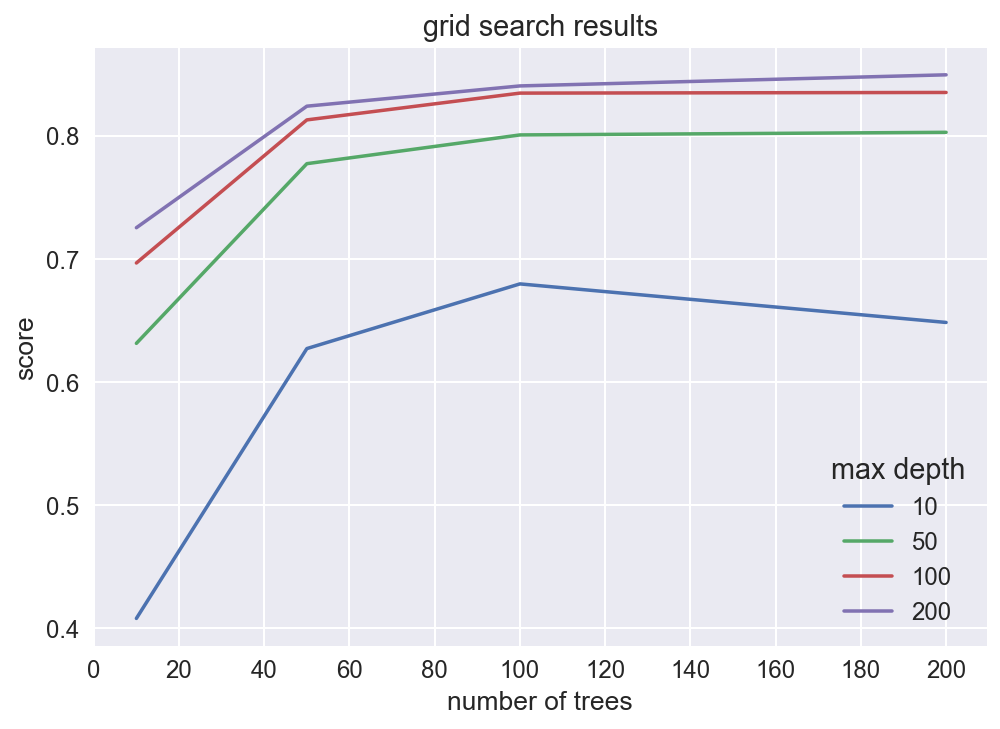

In [92]:
for arr in scores_:
    plt.plot([10, 50, 100, 200], arr)
plt.legend(['10', '50', '100', '200'], title='max depth')
plt.title('grid search results')
plt.xlabel('number of trees')
plt.xticks(range(0, 220, 20))
plt.ylabel('score')

### 2.2.2 Display confusion matrix
For each class, we compute the sensitivity, accuracy, specificity and precision.

$$sensitivity = \frac{TP}{TP + FN}$$

$$precision = \frac{TP}{TP + FP}$$

$$specificity = \frac{TN}{TN + FP}$$

$$accuracy = \frac{TN + TP}{TP + FN + FP + TN}$$

Now, let's fit the model with the best parameters we found with the grid search:

In [93]:
rand_forest_model = RandomForestClassifier(n_estimators=100, max_depth=100)
rand_forest_model.fit(X_train, y_train)
y_pred_test = rand_forest_model.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.84766454352441611

Let's plot the confusion matrix:

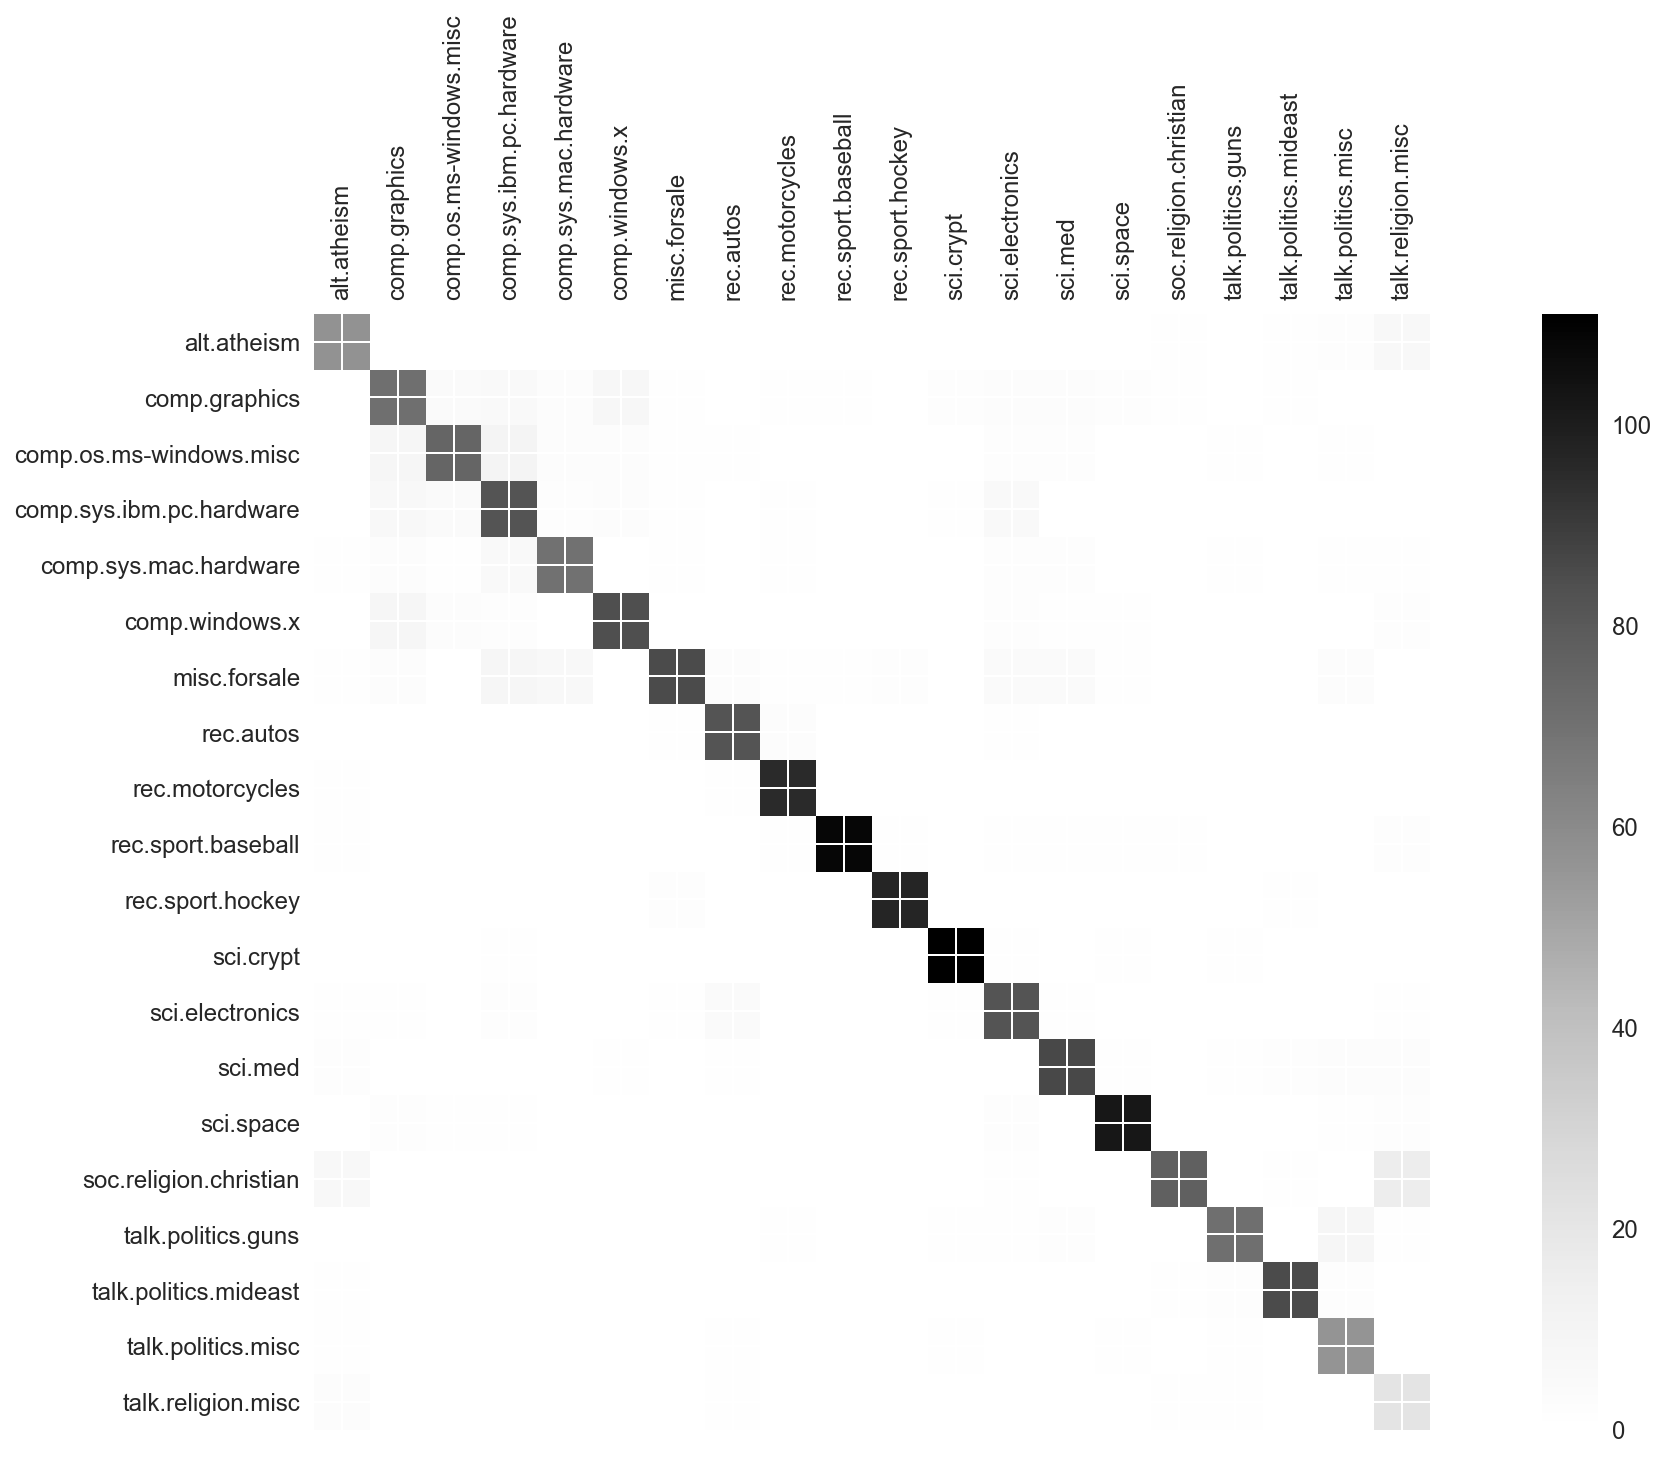

In [94]:
cm = confusion_matrix(y_pred_test, y_test)
plt.figure(num=1, figsize=(20,10))
plt.matshow(cm, fignum=1)
plt.colorbar()
plt.xticks(range(20), newsgroups.target_names, rotation='vertical')
plt.yticks(range(20), newsgroups.target_names)
plt.show()


As we can see, most classes match well. There are a few classes that are a bit confused with one another, for example we see that *soc.religion.christian* and *talk.religion.misc* are not clearly differentiated.

### Analyze the precision and recall (sensitivity) of each class 
Precision and recall are two common measures that give a good feeling of the quality of a classification model. The **precision** is the fraction of relevant instances among the retrieved instances, while the **recall** is the fraction of relevant instances that have been retrieved over the total amount of relevant instances.

In other words:

- a class will have a **bad precision** if a lot of elements that do not belong to this class are predicted to be in it
- a class will have a **bad recall** if a lot of elements that actually belong to this class are not predicted to be in it.


In [95]:
confm = pd.DataFrame(cm, index=newsgroups.target_names, columns=newsgroups.target_names)
confm.head()

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,6
comp.graphics,0,71,4,5,3,7,1,0,1,1,0,2,3,3,2,1,0,1,0,0
comp.os.ms-windows.misc,0,8,75,10,3,3,1,1,0,0,0,0,2,2,0,0,1,0,1,0
comp.sys.ibm.pc.hardware,0,6,4,82,2,3,1,0,1,0,0,1,5,0,0,0,0,0,0,0
comp.sys.mac.hardware,1,3,1,5,70,0,1,0,1,0,0,0,2,2,0,0,1,0,1,1


In [96]:
confusion = pd.DataFrame(index=newsgroups.target_names)
# compute True/False Positive/Negative rates
confusion['TP'] = np.diag(cm)
confusion['FP'] = confm.sum(axis=0) - confusion['TP']
confusion['FN'] = confm.sum(axis=1) - confusion['TP']
confusion['TN'] = confm.sum().sum() - confusion['TP'] - confusion['FN'] - confusion['FP']
# compute sensitivity, accuracy, specificity and precision
confusion['sensitivity'] = confusion['TP'] / (confusion['TP'] + confusion['FN'])
confusion['accuracy'] = (confusion['TN'] + confusion['TP']) / confm.sum().sum()
confusion['specificity'] = confusion['TN'] / (confusion['TN'] + confusion['FP'])
confusion['precision'] = confusion['TP'] / (confusion['TP'] + confusion['FP'])

confusion.head()

,TP,FP,FN,TN,sensitivity,accuracy,specificity,precision
alt.atheism,57,18,10,1799,0.850746,0.985138,0.990094,0.760000
comp.graphics,71,31,34,1748,0.676190,0.965499,0.982574,0.696078
comp.os.ms-windows.misc,75,13,32,1764,0.700935,0.976115,0.992684,0.852273
comp.sys.ibm.pc.hardware,82,34,23,1745,0.780952,0.969745,0.980888,0.706897
comp.sys.mac.hardware,70,14,19,1781,0.786517,0.982484,0.992201,0.833333


As we can see in the following plot, the results are quite satisfying in a general manner. However we notice that the class *talk.religion.misc* has a bad precision, which means that some news that do not belong to this class are predicited to be in it. By looking at the confusion matrix, it seems that these confusing news come from the *soc.religion.christian* class.

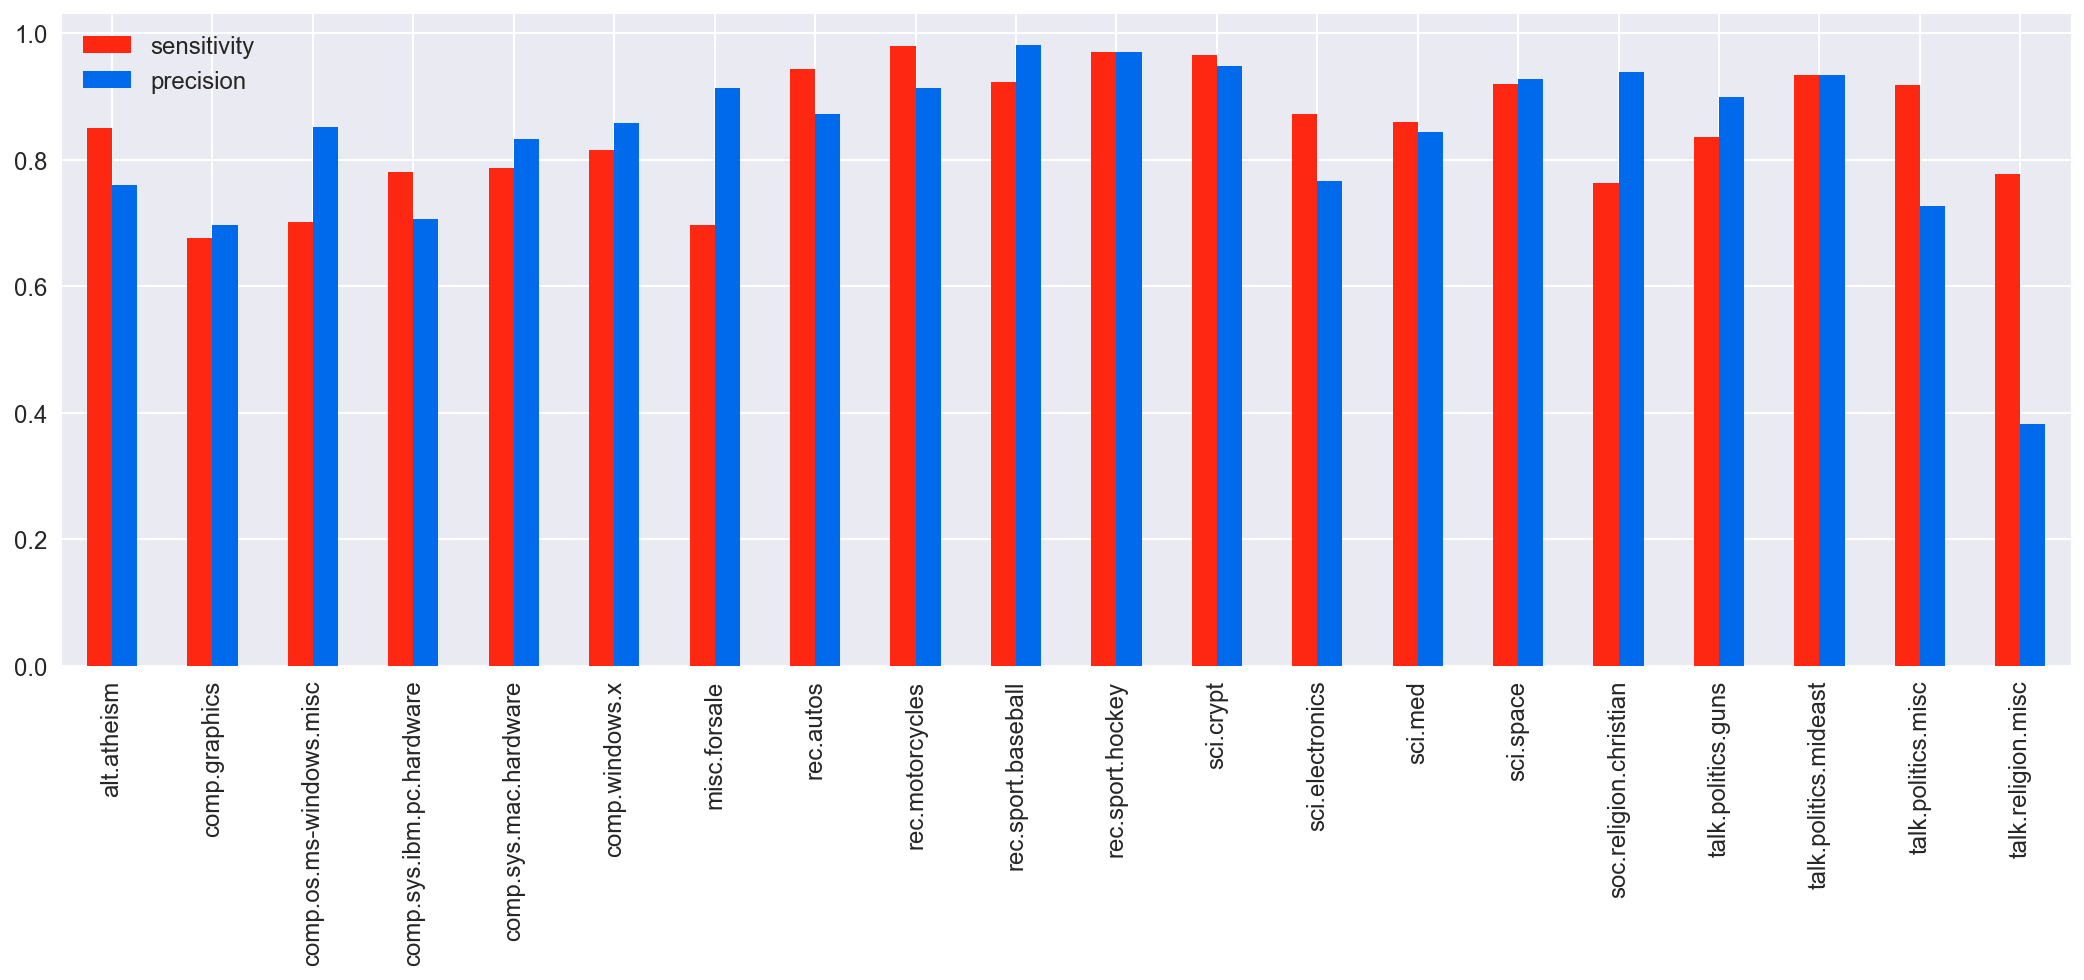

In [97]:
axes = confusion[['sensitivity', 'precision']].plot(kind='bar',
               stacked=False,
               figsize=(18, 6),
               color=['#FE2712', '#006aed'],
               fontsize=12,
               legend=True
              )

### 2.2.3 Features importance
Inspect the *feature importances* attribute of the random forest.

In [98]:
importances = rand_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_forest_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d -> %s (importance %f)" % (f + 1, indices[f], 
                                    np.array(vectorizer.get_feature_names())[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 139570 -> sale (importance 0.005683)
2. feature 65684 -> dod (importance 0.005139)
3. feature 46061 -> bike (importance 0.004685)
4. feature 165812 -> windows (importance 0.004477)
5. feature 52100 -> car (importance 0.003936)
6. feature 55485 -> clipper (importance 0.003894)
7. feature 145613 -> space (importance 0.002834)
8. feature 119845 -> of (importance 0.002730)
9. feature 152603 -> the (importance 0.002691)
10. feature 85770 -> hockey (importance 0.002464)
11. feature 138451 -> rutgers (importance 0.002416)
12. feature 152582 -> that (importance 0.002376)
13. feature 80391 -> god (importance 0.002374)
14. feature 92333 -> israel (importance 0.002244)
15. feature 89701 -> in (importance 0.002202)
16. feature 153971 -> to (importance 0.002187)
17. feature 133530 -> re (importance 0.002187)
18. feature 166913 -> writes (importance 0.002120)
19. feature 105625 -> mac (importance 0.002119)
20. feature 151673 -> team (importance 0.002053)


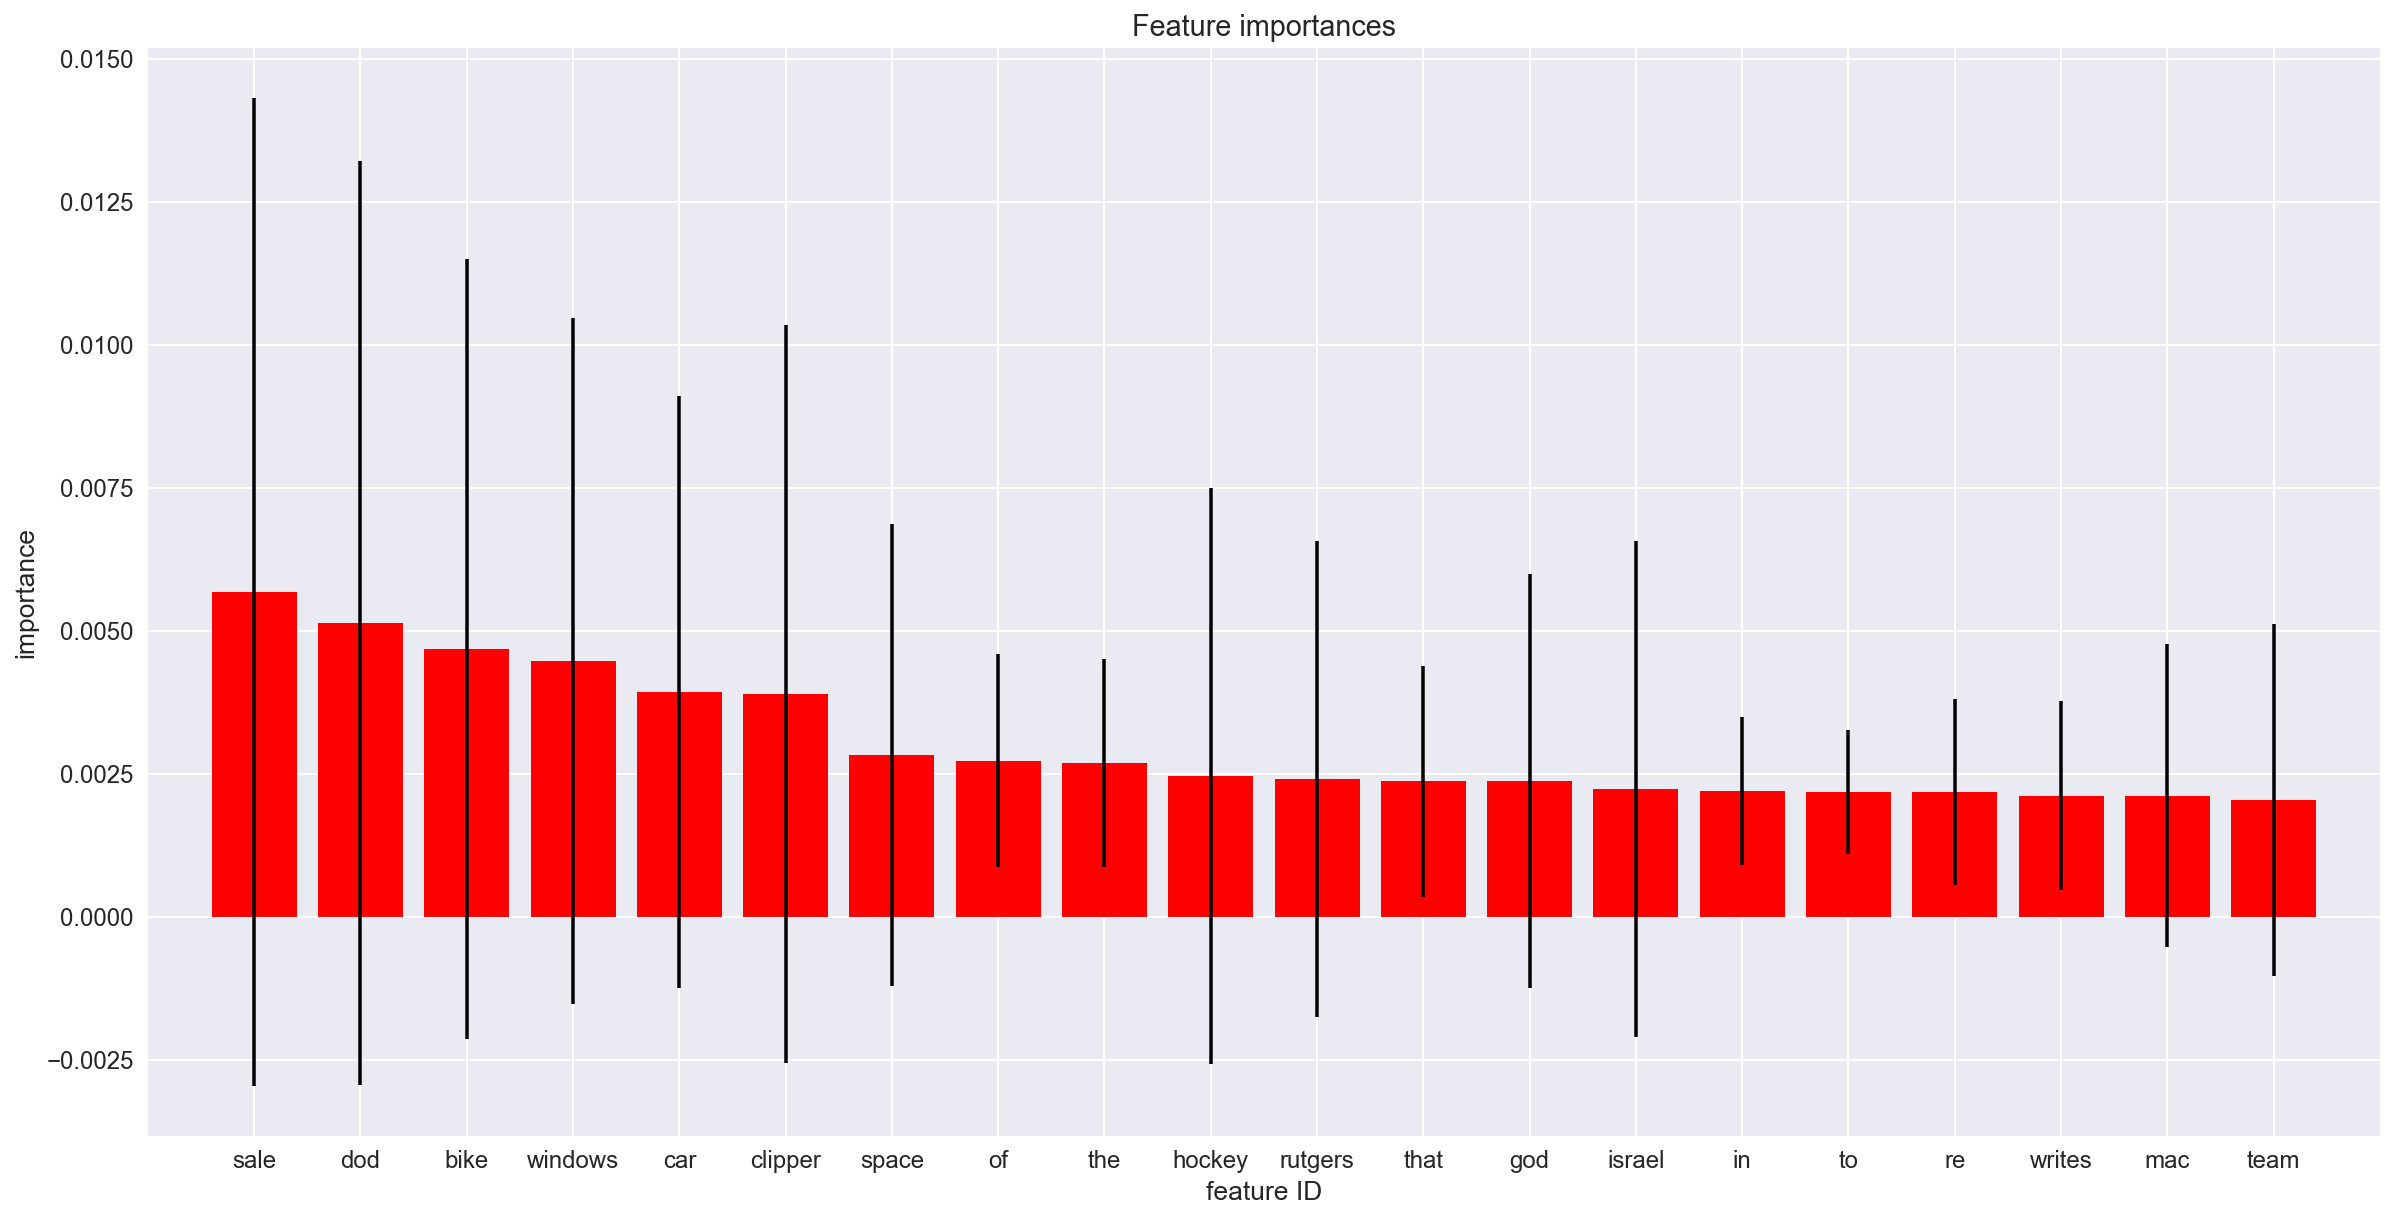

In [99]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.xlabel('feature ID')
plt.ylabel('importance')
plt.bar(range(20), importances[indices[:20]],
       color="r", yerr=std[indices[:20]], align="center")
plt.xticks(range(20), np.array(vectorizer.get_feature_names())[indices[:20]])
plt.xlim([-1, 20])
plt.show()

Looking at the twenty first features, we understand that most of them belong to some easily identified classes as 'cars', 'god' or 'sale'. However some very words common words such as 'of', 'that' or 'in' should not be present in the top most important features because they do not give any insight on which class the article should belong to.